In [1]:
import gymnasium as gym
from bettermdptools.algorithms.planner import Planner
from bettermdptools.utils.plots import Plots
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from bettermdptools.utils.test_env import TestEnv
from mountainCartWrapper2 import MountainCartWrapper
from tqdm import tqdm
import seaborn as sns

import pickle
import numpy as np
import pandas as pd
import random

from utils import *

np.random.seed(42)
random.seed(42)

%load_ext autoreload
%autoreload 2


## 0. First tries

In [2]:
size = 160
map_size = (size, size)
mc = gym.make('MountainCar-v0', render_mode="rgb_array", max_episode_steps=1000)
env = MountainCartWrapper(mc, discrete_step=size)

In [3]:
V, V_track, pi, pi_track, timings  = Planner(env.P).value_iteration(gamma=0.999, theta=1e-8, n_iters=10000)
# V, V_track, pi, pi_track, timings, total_updates  = Planner(env.P).policy_iteration(gamma=0.99, theta=1e-8, n_iters=100000)

Total Q updates: 9753600
runtime = 7.54 seconds


In [237]:
def one_shot_eval(env, pi):
    episode_rewards, run_length, _ = TestEnv.test_env(env=env, n_iters=100, pi=pi, convert_state_obs=lambda state : env.convert_2d_to_1d(state))
    episode_rewards = np.array(episode_rewards)
    print(f"Mean reward: {np.mean(episode_rewards)}")
    
one_shot_eval(env, pi)

Mean reward: -389.01


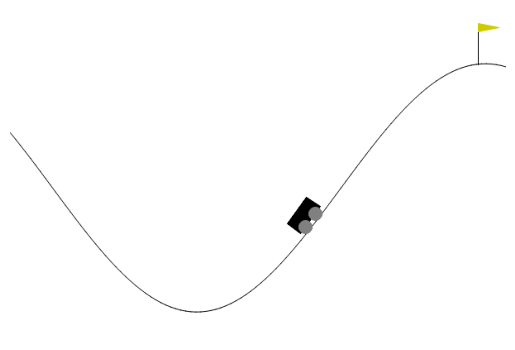

In [27]:
%matplotlib inline
plt.style.use('ggplot')
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


#  Let's see how the agent performs in the environment by running a single iteration of 1000 steps
# and rendering the environment at each step
env.reset()
state = env.state
# print(state)

img = plt.imshow(env.render())
state = env.transform_obs(state)

for t in range(300):
    state = env.convert_2d_to_1d(state)
    action = pi[state]
    img.set_data(env.render())
    # add the action on the image
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, b, c = env.step(action)
    test = env._inverse_transform_obs(state)
    if done:
        print('Score: ', t+1)
        break
        
env.close()

Number of policy changes: 1000


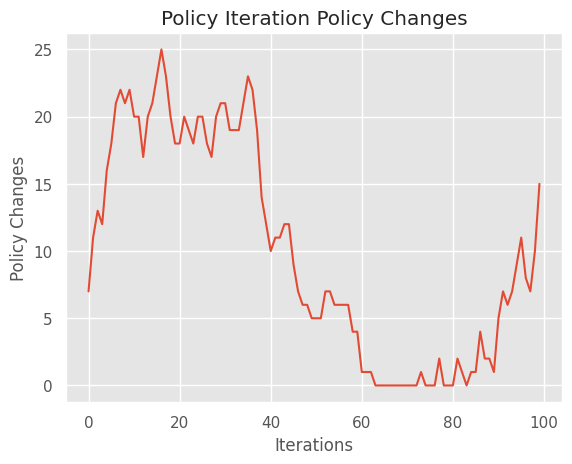

In [12]:
def policies_changes_plot(pi_tracks, title, upper_bound=100):

    # find the longest pi_track
    max_len = max([len(pi_track) for pi_track in pi_tracks])
    # pad the pi_tracks with the last policy to have the same length
    for pi_track in pi_tracks:
        while len(pi_track) < max_len:
            pi_track.append(pi_track[-1])


    for pi_track in pi_tracks:
        changes = []
        for i in range(1, upper_bound+1):
            if len(pi_track) == i:
                break
            # count the number of different values between the two policies betweeen i and i-1 (they are dictionaries)
            n_changes = sum([1 for key in pi_track[i] if pi_track[i][key] != pi_track[i-1][key]])

            changes.append(n_changes)
        plt.plot(changes)
        print(f"Number of policy changes: {np.sum(changes)}")
    if upper_bound < 10:
        plt.xticks(range(upper_bound))    
    plt.xlabel("Iterations")
    plt.ylabel("Policy Changes")
    plt.title(title)
    # plt.legend(["20x20","8x8", "4x4"])
    plt.show()

policies_changes_plot([pi_track], "Policy Iteration Policy Changes", upper_bound=100)

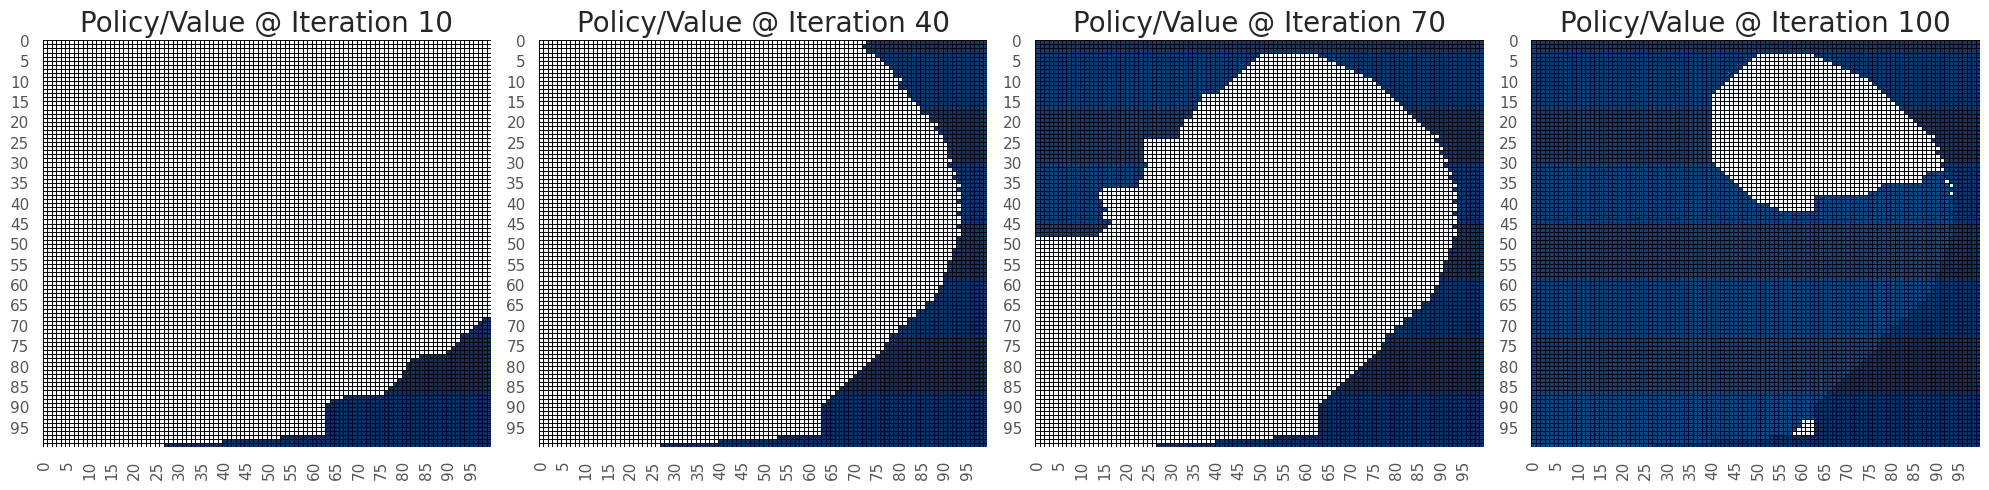

In [16]:
def plot_multiple_policies(V_track, pi_track,  indices = [5,10,25,50], map_size=(8,8), filename=None):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    fl_actions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    fl_map_size=(10,10)

    for i, idx in enumerate(indices):
        val_max, policy_map = Plots.get_policy_map(pi_track[idx], V_track[idx], fl_actions, map_size)
        sns.heatmap(
            val_max,
            # annot=policy_map,
            annot=False,
            fmt="",
            cmap=sns.color_palette("Blues", as_cmap=True),
            linewidths=0.7,
            linecolor="black",
            # annot_kws={"fontsize": "xx-large", "fontweight": "bold", "color": "black", "style": "italic"},
            ax=axs[i],
            cbar = False
        )
        axs[i].set_title(f"Policy/Value @ Iteration {idx}", fontsize=20)

    if filename:
        plt.tight_layout()
        plt.savefig(f'figures/frozen_lake/{filename}.pdf', format='pdf', bbox_inches='tight')
    plt.show()

plot_multiple_policies(V_track, pi_track, indices=[10,40,70,100], map_size=map_size, filename="frozen_lake_policy_iteration")

## 1. Here we show the impact of discretization

In [147]:
# Let's test how the mean value function converges with different discretization levels
discretization_levels = [20,40,60,80,100,120,140,160,180,200]
V_tracks = []
pi_tracks = []
for size in tqdm(discretization_levels):
    print(f"Running for size: {size}")
    env = gym.make('MountainCar-v0', render_mode="rgb_array", max_episode_steps=1000)
    env = MountainCartWrapper(env, discrete_step=size)
    V, V_track, pi, pi_track, timings  = Planner(env.P).value_iteration(gamma=0.999, theta=1e-10, n_iters=1000)
    V_tracks.append(V_track)
    pi_tracks.append(pi_track)

 20%|██        | 2/10 [00:00<00:00, 11.71it/s]

Running for size: 20
Total Q updates: 2400
runtime = 0.00 seconds
Running for size: 40
Total Q updates: 48000
runtime = 0.03 seconds
Running for size: 60
Total Q updates: 248400
runtime = 0.18 seconds
Running for size: 80


 40%|████      | 4/10 [00:01<00:03,  1.88it/s]

Total Q updates: 998400
runtime = 0.71 seconds
Running for size: 100


 50%|█████     | 5/10 [00:05<00:07,  1.42s/it]

Total Q updates: 4050000
runtime = 2.90 seconds
Running for size: 120


 60%|██████    | 6/10 [00:10<00:10,  2.59s/it]

Total Q updates: 6350400
runtime = 4.40 seconds
Running for size: 140


 70%|███████   | 7/10 [00:18<00:12,  4.13s/it]

Total Q updates: 7526400
runtime = 6.28 seconds
Running for size: 160


 80%|████████  | 8/10 [00:29<00:12,  6.18s/it]

Total Q updates: 9753600
runtime = 8.66 seconds
Running for size: 180


 90%|█████████ | 9/10 [00:41<00:07,  7.90s/it]

Total Q updates: 11469600
runtime = 9.03 seconds
Running for size: 200


100%|██████████| 10/10 [00:57<00:00,  5.77s/it]

Total Q updates: 14880000
runtime = 13.10 seconds


In [148]:
def v_iters_plot_gammas(V_tracks, discretization_levels, mode="mean"):
    plt.figure(figsize=(10, 5))
    # find the length of the longest V_track with trim  zeros
    max_len = max([len(np.trim_zeros(np.mean(V_track, axis=1), "b")) for V_track in V_tracks])
    for (V_track, size) in zip(V_tracks, discretization_levels):
        if mode == "mean":
            value_per_iter = np.trim_zeros(np.mean(V_track, axis=1), "b")
            std_value_per_iter = np.trim_zeros(np.std(V_track, axis=1), "b")
        elif mode == "max":
            value_per_iter = np.trim_zeros(np.max(V_track, axis=1), "b")
            std_value_per_iter = np.trim_zeros(np.std(V_track, axis=1), "b")
        else:
            raise ValueError("Mode must be either 'mean' or 'max'")
        std_value_per_iter = std_value_per_iter ** 3

        # pad the shorter V_track with last value
        value_per_iter = np.pad(value_per_iter, (0, max_len - len(value_per_iter)), mode="edge")
        std_value_per_iter = np.pad(std_value_per_iter, (0, max_len - len(std_value_per_iter)), mode="edge")

        plt.plot(value_per_iter, label=f"{size}x{size}", linewidth=2)
    plt.xlabel("Iterations", fontsize=25)
    if mode == "mean":
        plt.ylabel("Mean V", fontsize=25)
    else:
        plt.ylabel("Max V", fontsize=25)

    # increase font of xticks and yticks
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    # add legend above the plot
    plt.legend(loc="upper center",bbox_to_anchor=(0.5, 1.23),shadow=False, ncol=5,fontsize=14)

    # plt.legend(loc='upper left', fontsize=14)
    plt.savefig(f"figures/mountain_cart/{mode}_V_iters.pdf", format="pdf", bbox_inches="tight")
    plt.show()

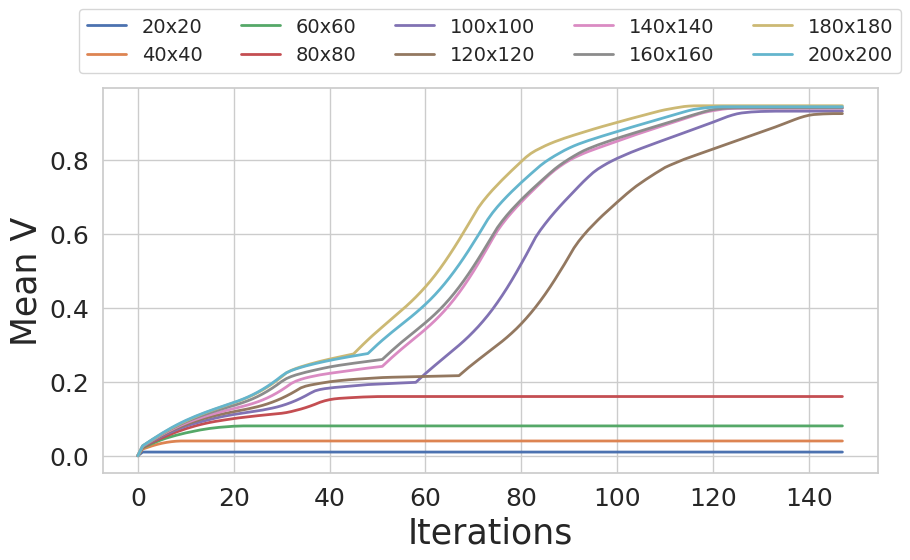

In [181]:
v_iters_plot_gammas(V_tracks, discretization_levels, mode="mean")

In [183]:
# for each discretization level, get the mean reward over 100 episodes of the last policy
rewards = []
for (size, pi_track) in zip(discretization_levels, pi_tracks):
    env = gym.make('MountainCar-v0', render_mode="rgb_array", max_episode_steps=1000)
    env = MountainCartWrapper(env, discrete_step=size)
    _, run_length, _ = TestEnv.test_env(env=env, n_iters=100, pi=pi_track[-1], convert_state_obs=lambda state : env.convert_2d_to_1d(state))
    rewards.append(np.mean(run_length))

Text(0, 0.5, 'Mean Steps to Goal')

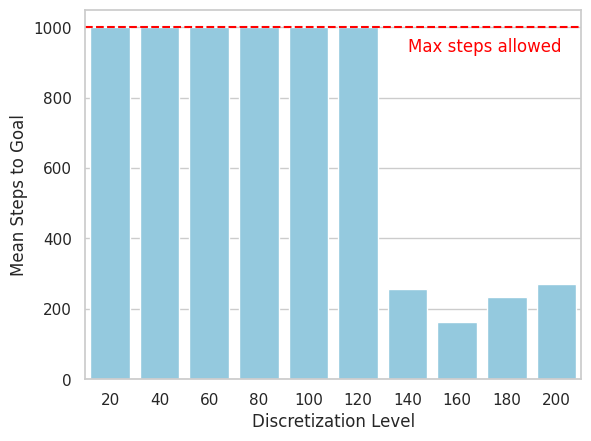

In [116]:
# barplot
sns.barplot(x=discretization_levels, y=rewards, color="skyblue")
# add horizontal line at 1000 steps
plt.axhline(1000, color='red', linestyle='--')
# add a text below the line "max steps allowed"
plt.text(6, 930, "Max steps allowed", color = 'red', fontsize=12)
plt.xlabel("Discretization Level")
plt.ylabel("Mean Steps to Goal")

In [188]:
# now let's make the exact same plot but with the mean reward per iteration
pi_tracks_reduces = pi_tracks[5:]
discretization_levels_reduces = discretization_levels[5:]
mean_rewards = []
mean_length = []
for pi_track, size in zip(pi_tracks_reduces, discretization_levels_reduces):
    rewards = []
    run_lengths = []
    for i in tqdm(range(0,len(pi_track), 10)):
        mc = gym.make('MountainCar-v0', render_mode="rgb_array", max_episode_steps=400)
        env = MountainCartWrapper(mc, discrete_step=size)
        episode_rewards, run_length, _ = TestEnv.test_env(env=env, n_iters=100, pi=pi_track[i], convert_state_obs=lambda state : env.convert_2d_to_1d(state))
        episode_rewards = np.array(episode_rewards)
        rewards.append(np.mean(episode_rewards))
        run_lengths.append(np.mean(run_length))
    mean_length.append(run_lengths)
    mean_rewards.append(rewards)



  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 13/13 [01:29<00:00,  6.91s/it]


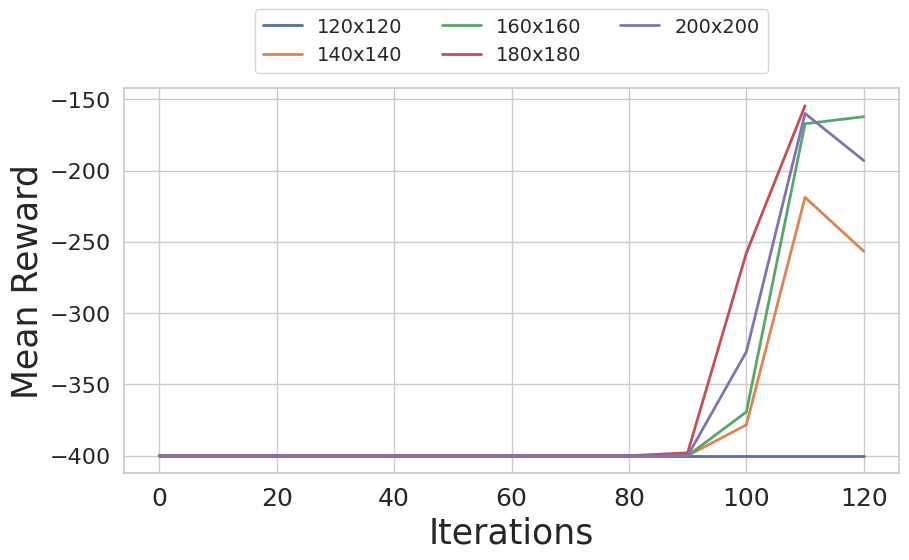

In [207]:
plt.figure(figsize=(10, 5))
for rewards, size, pi_track in zip(mean_rewards, discretization_levels_reduces, pi_tracks_reduces):
    if size == 120:
        plt.plot(range(0,121, 10),rewards[:13], label=f"{size}x{size}", linewidth=2)
    else:
        plt.plot(range(0,len(pi_track), 10),rewards, label=f"{size}x{size}", linewidth=2)
plt.xlabel("Iterations", fontsize=25)
plt.ylabel("Mean Reward", fontsize=25)
plt.legend(loc="upper center",bbox_to_anchor=(0.5, 1.23),shadow=False, ncol=3,fontsize=14)

plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.savefig(f"figures/mountain_cart/mean_reward_vi_iters.pdf", format="pdf", bbox_inches="tight")


In [157]:
size = 100
map_size = (size, size)
mc = gym.make('MountainCar-v0', render_mode="rgb_array", max_episode_steps=1000)
env = MountainCartWrapper(mc, discrete_step=size)
V_100, V_track, pi, pi_track, timings  = Planner(env.P).value_iteration(gamma=0.999, theta=1e-10, n_iters=1000)

size = 80
map_size = (size, size)
mc = gym.make('MountainCar-v0', render_mode="rgb_array", max_episode_steps=1000)
env = MountainCartWrapper(mc, discrete_step=size)
V_80, V_track, pi, pi_track, timings  = Planner(env.P).value_iteration(gamma=0.999, theta=1e-10, n_iters=1000)

size = 160
map_size = (size, size)
mc = gym.make('MountainCar-v0', render_mode="rgb_array", max_episode_steps=1000)
env = MountainCartWrapper(mc, discrete_step=size)
V_160, V_track, pi, pi_track, timings  = Planner(env.P).value_iteration(gamma=0.999, theta=1e-10, n_iters=1000)



Total Q updates: 4050000
runtime = 3.32 seconds
Total Q updates: 998400
runtime = 0.78 seconds
Total Q updates: 9753600
runtime = 7.85 seconds


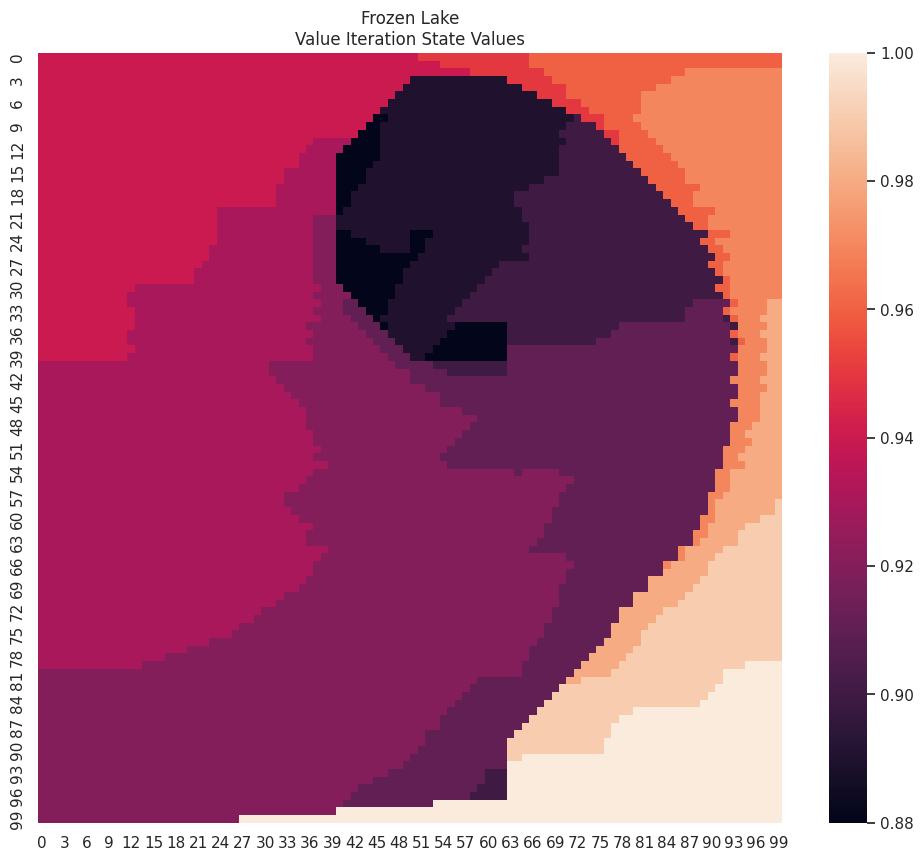

In [161]:
Plots.values_heat_map(V_100, "Frozen Lake\nValue Iteration State Values", (100,100), annot=False, figsize=(12,10))

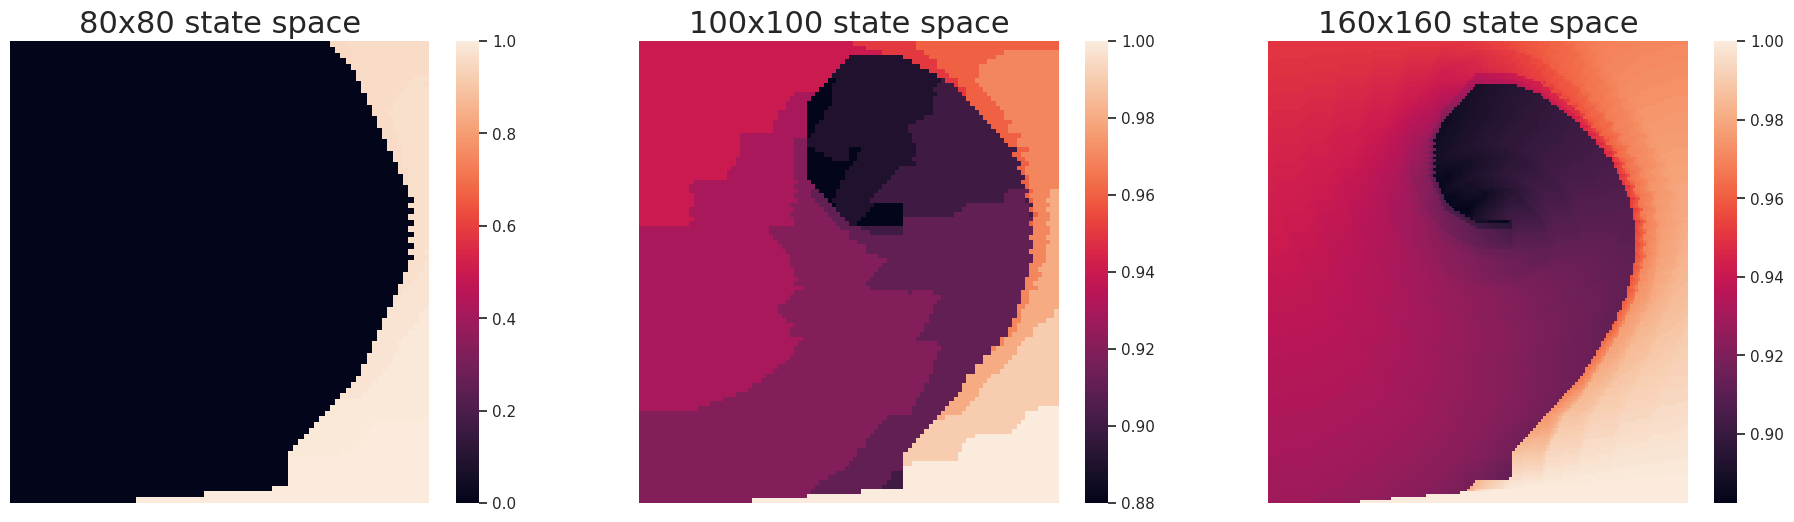

In [177]:
def plot_all_size_heat_maps(V_1, V_2, V_3):
    fig, ax = plt.subplots(1, 3, figsize=(23, 6))

    # sns heatmap
    V_1 = np.around(np.array(V_1).reshape((80,80)), 2)
    sns.heatmap(V_1, annot=False, ax=plt, cbar=True)
    plt.set_title("80x80 state space", fontsize=22)
    plt.set_xticks([])
    plt.set_yticks([])

    # ax[1].imshow(V_8.reshape(8, 8))
    V_2 = np.around(np.array(V_2).reshape((100, 100)), 2)
    sns.heatmap(V_2, annot=False, ax=ax[1], cbar=True)
    ax[1].set_title("100x100 state space", fontsize=22)
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    # ax[2].imshow(V_20.reshape(20, 20))
    sns.heatmap(V_3.reshape(160, 160), annot=False, ax=ax[2], cbar=True)
    ax[2].set_title("160x160 state space", fontsize=22)
    ax[2].set_xticks([])
    ax[2].set_yticks([])

    plt.savefig("figures/mountain_cart/value_iteration_state_values.pdf", bbox_inches='tight', dpi=300)
    plt.show()

plot_all_size_heat_maps(V_80, V_100, V_160)

## 2. VI

In [268]:
size = 160
map_size = (size, size)
mc = gym.make('MountainCar-v0', render_mode="rgb_array", max_episode_steps=400)
env = MountainCartWrapper(mc, discrete_step=size)

In [270]:
results = value_iter_grid_search(env, 20000, [0.5, 0.75, 0.9, 0.99, 0.999], [1e-4, 1e-8, 1e-12, 1e-15], convert_state_obs=lambda state : env.convert_2d_to_1d(state))

Running value iteration for gamma=0.5 and theta=0.0001
Total Q updates: 1152000
runtime = 0.85 seconds
Mean reward: -400.0

Running value iteration for gamma=0.5 and theta=1e-08
Total Q updates: 2150400
runtime = 1.59 seconds
Mean reward: -400.0

Running value iteration for gamma=0.5 and theta=1e-12
Total Q updates: 3148800
runtime = 2.46 seconds
Mean reward: -400.0

Running value iteration for gamma=0.5 and theta=1e-15
Total Q updates: 3916800
runtime = 3.16 seconds
Mean reward: -400.0

Running value iteration for gamma=0.75 and theta=0.0001
Total Q updates: 2611200
runtime = 2.08 seconds
Mean reward: -400.0

Running value iteration for gamma=0.75 and theta=1e-08
Total Q updates: 5068800
runtime = 3.91 seconds
Mean reward: -400.0

Running value iteration for gamma=0.75 and theta=1e-12
Total Q updates: 7526400
runtime = 6.04 seconds
Mean reward: -400.0

Running value iteration for gamma=0.75 and theta=1e-15
Total Q updates: 9369600
runtime = 7.31 seconds
Mean reward: -165.434

Running 

In [253]:
# values are: V, V_track, pi, pi_track, mean_reward, timings

In [293]:
df = pd.DataFrame(columns=['gamma', 'theta', 'reward', 'timings'])
for key in results:
    new_row = {}
    new_row['gamma'] = key[0]
    new_row['theta'] = key[1]
    new_row['reward'] = results[key][4]
    new_row['timings'] = np.sum(results[key][5])
    # add the new row to the dataframe
    df2 = pd.DataFrame(new_row, index=[0])
    df = pd.concat([df, df2], ignore_index=True)

/tmp/ipykernel_8246/957640899.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df2], ignore_index=True)


In [296]:
# save df to pickle
df.to_pickle("checkpoints/mountain_cart_value_iteration_grid_search_results.pkl")

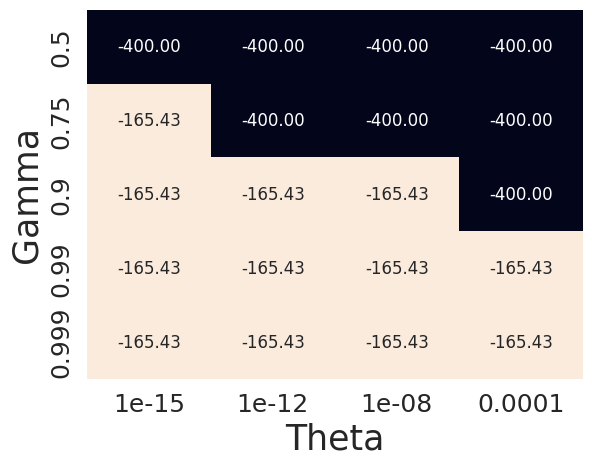

In [292]:
df_pivot = df.pivot_table(index='gamma', columns='theta', values='reward', aggfunc='mean')
sns.heatmap(df_pivot, annot=True, fmt=".2f", cbar=False)
# plt.title("Q-Learning Hyperparameter Grid Search\nAverage Reward over 5 seeds")
plt.xlabel("Theta", fontsize=25)
plt.ylabel("Gamma", fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig("figures/mountain_cart/VI_grid_search.pdf", format="pdf", bbox_inches="tight")

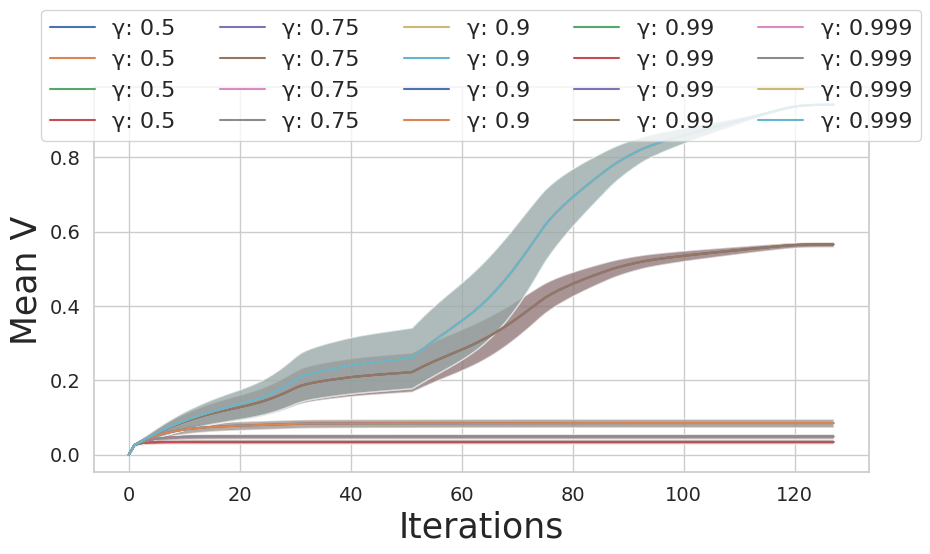

In [291]:
from utils import v_iters_plot_gammas

v_iters_plot_gammas(results, mode="mean")

<Axes: >

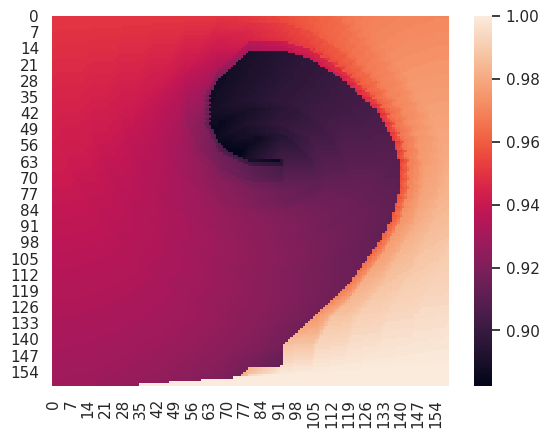

In [290]:
V = results[(0.999, 1e-15)][0]
V = np.array(V).reshape((160, 160))
sns.heatmap(V, annot=False, cbar=True)
# ax[1].set_title("100x100 state space", fontsize=22)
# ax[1].set_xticks([])
# ax[1].set_yticks([])

In [15]:
# load pickle
df = pd.read_pickle("checkpoints/mountain_cart_value_iteration_grid_search_results.pkl")
df


,gamma,theta,reward,timings
0,0.500,1.000000e-04,-400.000,0.845273
1,0.500,1.000000e-08,-400.000,1.586140
2,0.500,1.000000e-12,-400.000,2.458583
3,0.500,1.000000e-15,-400.000,3.154515
4,0.750,1.000000e-04,-400.000,2.072616
5,0.750,1.000000e-08,-400.000,3.908355
6,0.750,1.000000e-12,-400.000,6.038949
7,0.750,1.000000e-15,-165.434,7.309270
8,0.900,1.000000e-04,-400.000,5.218945
9,0.900,1.000000e-08,-165.434,9.921834


In [7]:
results = value_iter_grid_search(env, 1000, [0.9, 0.99, 0.999], [1e-8], convert_state_obs=lambda state : env.convert_2d_to_1d(state))

Running value iteration for gamma=0.9 and theta=1e-08
Total Q updates: 9753600
runtime = 6.96 seconds


/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Mean reward: -162.27

Running value iteration for gamma=0.99 and theta=1e-08
Total Q updates: 9753600
runtime = 7.14 seconds
Mean reward: -162.27

Running value iteration for gamma=0.999 and theta=1e-08
Total Q updates: 9753600
runtime = 6.82 seconds
Mean reward: -162.27



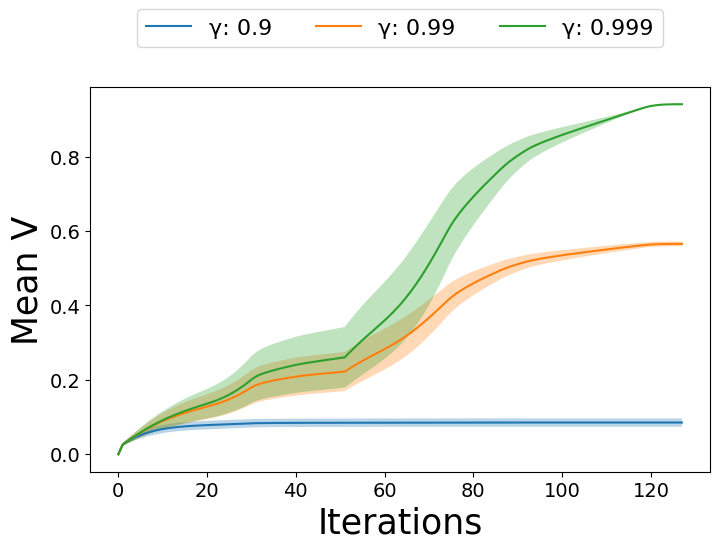

In [25]:
from utils import v_iters_plot_gammas

v_iters_plot_gammas(results, mode="mean")

In [10]:
del results

In [8]:
pi_tracks = []
for key in results:
    pi_tracks.append(results[key][3])

In [9]:
len(pi_tracks)

3

In [12]:
pi_track_VI =  pi_tracks[0]

In [6]:
def policies_changes_plot(pi_tracks, title, upper_bound=100):

    # find the longest pi_track
    max_len = max([len(pi_track) for pi_track in pi_tracks])
    # pad the pi_tracks with the last policy to have the same length
    for pi_track in pi_tracks:
        while len(pi_track) < max_len:
            pi_track.append(pi_track[-1])

    t = 0
    for pi_track in pi_tracks:
        changes = []
        for i in range(1, upper_bound+1):
            if len(pi_track) == i:
                break
            # count the number of different values between the two policies betweeen i and i-1 (they are dictionaries)
            n_changes = sum([1 for key in pi_track[i] if pi_track[i][key] != pi_track[i-1][key]])

            changes.append(n_changes)

        plt.plot(changes, label=f"{t}")
        t += 1
        print(f"Number of policy changes: {np.sum(changes)}")

    plt.xlabel("Iterations", fontsize=18)


    plt.ylabel("Policy Changes", fontsize=18)
    # plt.title(title)
    plt.legend(["γ=0.999", " γ=0.99", "γ=0.9"], fontsize=14)
    plt.savefig(f"figures/mountain_cart/{title}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

policies_changes_plot(pi_tracks, "mountain_cart_value_iterationçpolicy_chnages", upper_bound=2000)

NameError: name 'pi_tracks' is not defined

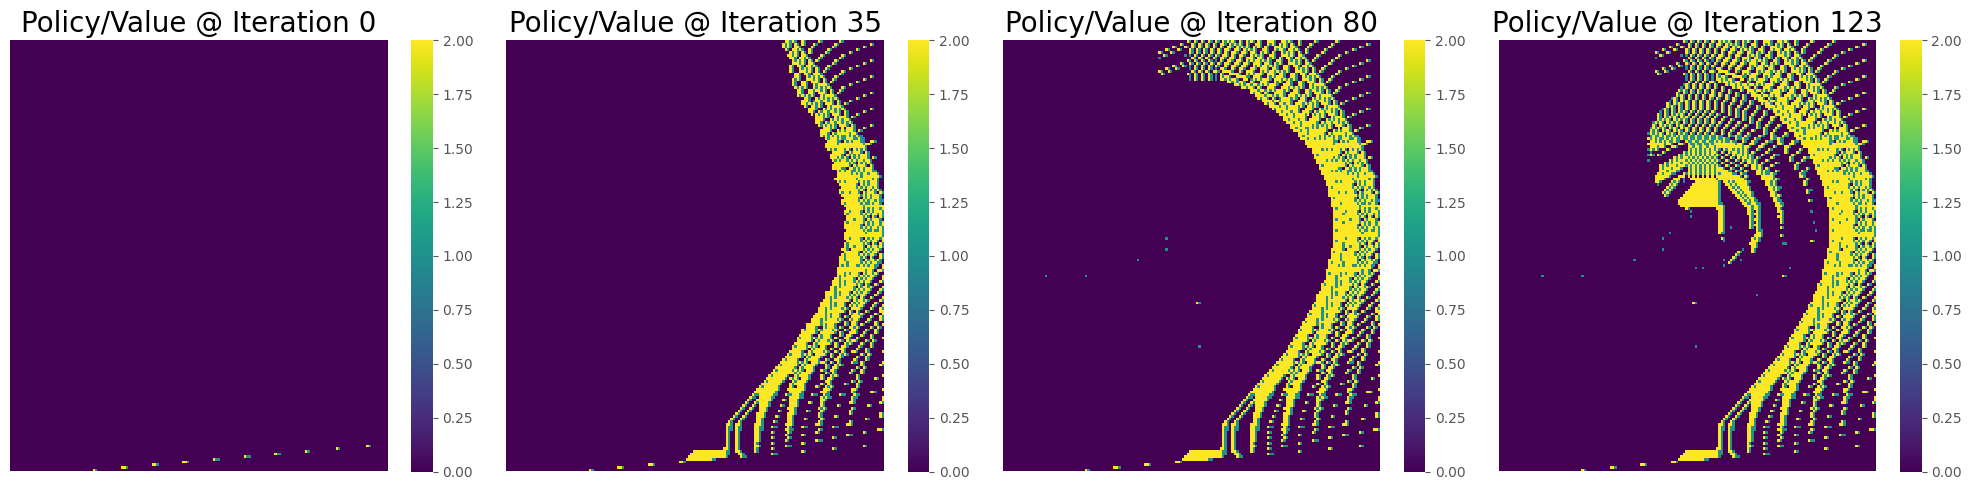

In [97]:
from utils import plot_multiple_policies
V_track = results[(0.99, 1e-8)][1]
pi_track = results[(0.99, 1e-8)][3]
plot_multiple_policies(V_track, pi_track, [0,35,80,123], map_size=(160,160), filename="160x160")

In [24]:
# Planner(env.P).value_iteration(gamma=0.99, theta=1e-8, n_iters=200)
V, V_track, pi, pi_track, timingS = Planner(env.P).policy_iteration(gamma=0.99, theta=1e-4, n_iters=200)

Total Q updates: 53401600
runtime = 30.86 seconds


Number of policy changes: 26875
Number of policy changes: 5522


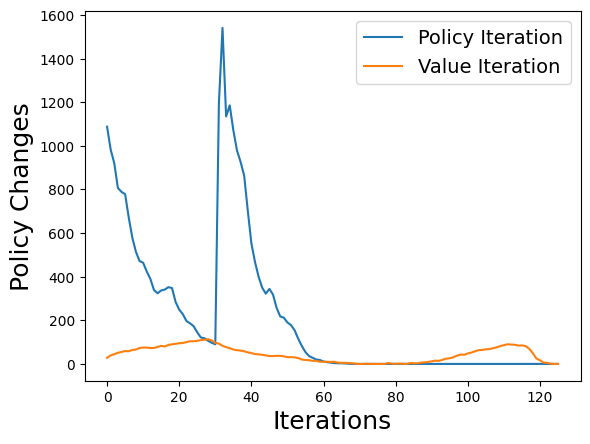

In [23]:
def policies_changes_plot(pi_tracks, title, upper_bound=100):

    # find the longest pi_track
    max_len = max([len(pi_track) for pi_track in pi_tracks])
    # pad the pi_tracks with the last policy to have the same length
    for pi_track in pi_tracks:
        while len(pi_track) < max_len:
            pi_track.append(pi_track[-1])

    t = 0
    for pi_track in pi_tracks:
        changes = []
        for i in range(1, upper_bound+1):
            if len(pi_track) == i:
                break
            # count the number of different values between the two policies betweeen i and i-1 (they are dictionaries)
            n_changes = sum([1 for key in pi_track[i] if pi_track[i][key] != pi_track[i-1][key]])

            changes.append(n_changes)

        plt.plot(changes, label=f"{t}")
        t += 1
        print(f"Number of policy changes: {np.sum(changes)}")

    plt.xlabel("Iterations", fontsize=18)


    plt.ylabel("Policy Changes", fontsize=18)
    # plt.title(title)
    plt.legend(["Policy Iteration", "Value Iteration"], fontsize=14)
    plt.savefig(f"figures/mountain_cart/{title}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

policies_changes_plot([pi_track, pi_track_VI], "mountain_cart_value_iterationçpolicy_chnages", upper_bound=2000)

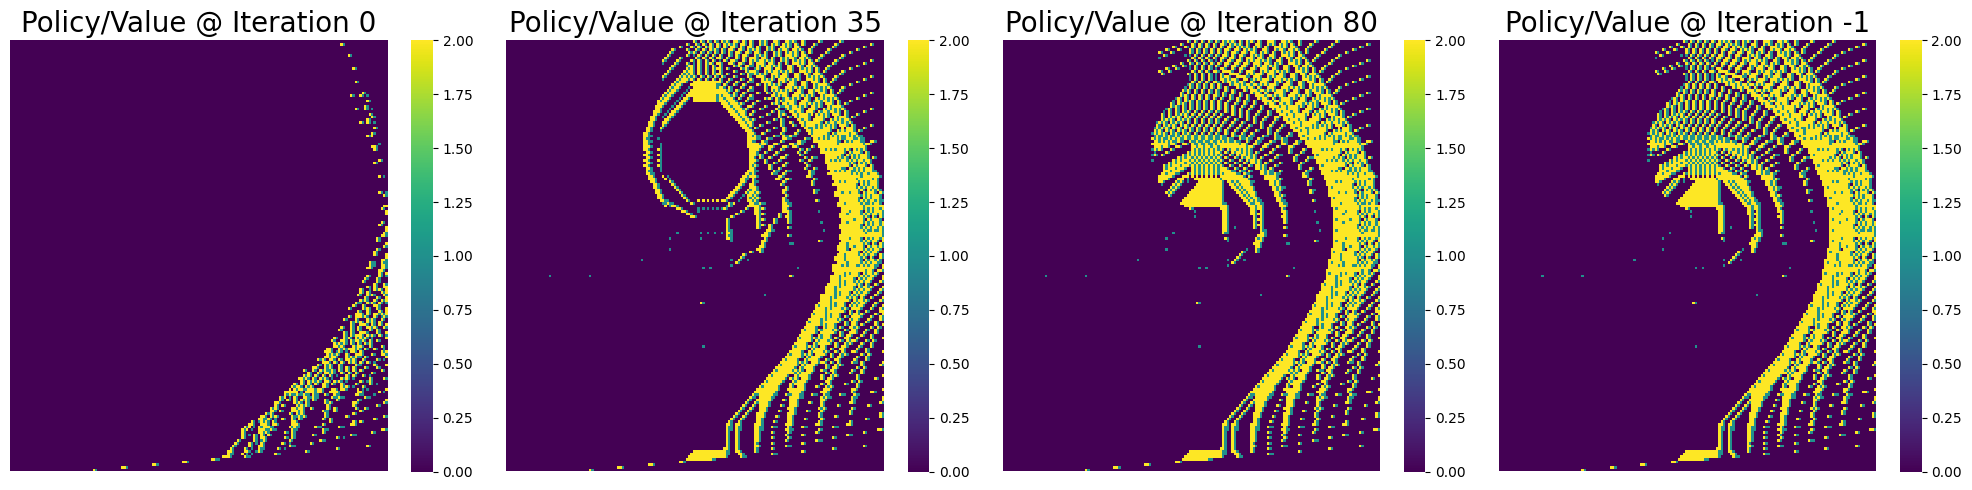

In [21]:
from utils import plot_multiple_policies,6°00
plot_multiple_policies(V_track, pi_track, [0,35,80,-1], map_size=(160,160), filename="160x160")

Score:  180


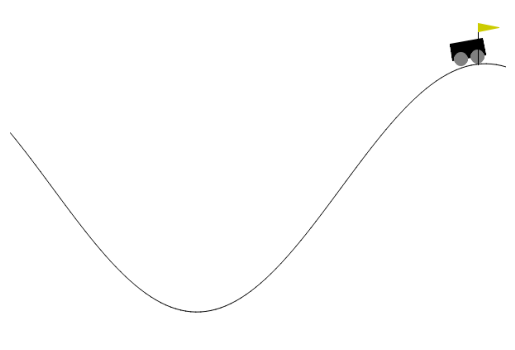

In [102]:
pi = pi_track[-1]

%matplotlib inline
plt.style.use('ggplot')
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


#  Let's see how the agent performs in the environment by running a single iteration of 1000 steps
# and rendering the environment at each step
env.reset()
state = env.state
# print(state)

img = plt.imshow(env.render())
state = env.transform_obs(state)

for t in range(300):
    state = env.convert_2d_to_1d(state)
    action = pi[state]
    img.set_data(env.render())
    # add the action on the image
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, b, c = env.step(action)
    test = env._inverse_transform_obs(state)
    if done:
        print('Score: ', t+1)
        break
        
env.close()

## 3. PI

In [4]:
size = 160
map_size = (size, size)
mc = gym.make('MountainCar-v0', render_mode="rgb_array", max_episode_steps=400)
env = MountainCartWrapper(mc, discrete_step=size)

In [5]:
results = policy_iter_grid_search(env, 20000, [0.5, 0.75, 0.9, 0.99, 0.999], [1e-4, 1e-8, 1e-12, 1e-15], convert_state_obs=lambda state : env.convert_2d_to_1d(state))

0it [00:00, ?it/s]

Running value iteration for gamma=0.5 and theta=0.0001
Total Q updates: 8396800
runtime = 6.78 seconds


/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
1it [00:08,  8.09s/it]

Mean reward: -400.0
Running value iteration for gamma=0.5 and theta=1e-08
Total Q updates: 12825600
runtime = 9.98 seconds


2it [00:19,  9.92s/it]

Mean reward: -400.0
Running value iteration for gamma=0.5 and theta=1e-12
Total Q updates: 19788800
runtime = 15.24 seconds


3it [00:35, 12.58s/it]

Mean reward: -162.27
Running value iteration for gamma=0.5 and theta=1e-15
Total Q updates: 18918400
runtime = 14.59 seconds


4it [00:50, 13.66s/it]

Mean reward: -233.12
Running value iteration for gamma=0.75 and theta=0.0001
Total Q updates: 13926400
runtime = 10.62 seconds


5it [01:02, 12.99s/it]

Mean reward: -400.0
Running value iteration for gamma=0.75 and theta=1e-08
Total Q updates: 22092800
runtime = 16.85 seconds


6it [01:19, 14.50s/it]

Mean reward: -179.45
Running value iteration for gamma=0.75 and theta=1e-12
Total Q updates: 30592000
runtime = 23.11 seconds


7it [01:43, 17.50s/it]

Mean reward: -179.45
Running value iteration for gamma=0.75 and theta=1e-15
Total Q updates: 36300800
runtime = 26.89 seconds


8it [02:10, 20.65s/it]

Mean reward: -162.27
Running value iteration for gamma=0.9 and theta=0.0001
Total Q updates: 25472000
runtime = 19.49 seconds


9it [02:30, 20.46s/it]

Mean reward: -179.45
Running value iteration for gamma=0.9 and theta=1e-08
Total Q updates: 44876800
runtime = 32.98 seconds


10it [03:04, 24.49s/it]

Mean reward: -162.27
Running value iteration for gamma=0.9 and theta=1e-12
Total Q updates: 51993600
runtime = 38.53 seconds


11it [03:43, 28.96s/it]

Mean reward: -162.27
Running value iteration for gamma=0.9 and theta=1e-15
Total Q updates: 53401600
runtime = 40.38 seconds


12it [04:24, 32.58s/it]

Mean reward: -162.27
Running value iteration for gamma=0.99 and theta=0.0001
Total Q updates: 53401600
runtime = 38.07 seconds


13it [05:02, 34.39s/it]

Mean reward: -162.27
Running value iteration for gamma=0.99 and theta=1e-08
Total Q updates: 53401600
runtime = 37.85 seconds


14it [05:41, 35.63s/it]

Mean reward: -162.27
Running value iteration for gamma=0.99 and theta=1e-12
Total Q updates: 53401600
runtime = 38.82 seconds


15it [06:20, 36.76s/it]

Mean reward: -162.27
Running value iteration for gamma=0.99 and theta=1e-15
Total Q updates: 53401600
runtime = 38.34 seconds


16it [06:59, 37.39s/it]

Mean reward: -162.27
Running value iteration for gamma=0.999 and theta=0.0001
Total Q updates: 53401600
runtime = 38.28 seconds


17it [07:38, 37.82s/it]

Mean reward: -162.27
Running value iteration for gamma=0.999 and theta=1e-08
Total Q updates: 53401600
runtime = 38.08 seconds


18it [08:16, 38.07s/it]

Mean reward: -162.27
Running value iteration for gamma=0.999 and theta=1e-12
Total Q updates: 53401600
runtime = 38.87 seconds


19it [08:56, 38.51s/it]

Mean reward: -162.27
Running value iteration for gamma=0.999 and theta=1e-15
Total Q updates: 53401600
runtime = 40.58 seconds


20it [09:37, 28.88s/it]

Mean reward: -162.27


In [6]:
df = pd.DataFrame(columns=['gamma', 'theta', 'reward', 'timings'])
for key in results:
    new_row = {}
    new_row['gamma'] = key[0]
    new_row['theta'] = key[1]
    new_row['reward'] = results[key][4]
    new_row['timings'] = np.sum(results[key][5])
    # add the new row to the dataframe
    df2 = pd.DataFrame(new_row, index=[0])
    df = pd.concat([df, df2], ignore_index=True)

/tmp/ipykernel_24070/957640899.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df2], ignore_index=True)


In [9]:
del results

In [8]:
# save df to pickle
df.to_pickle("checkpoints/mountain_cart_policy_iteration_grid_search_results.pkl")

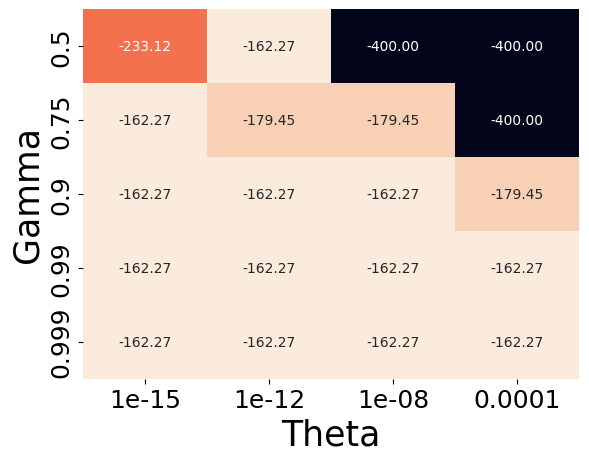

In [10]:
df_pivot = df.pivot_table(index='gamma', columns='theta', values='reward', aggfunc='mean')
sns.heatmap(df_pivot, annot=True, fmt=".2f", cbar=False)
# plt.title("Q-Learning Hyperparameter Grid Search\nAverage Reward over 5 seeds")
plt.xlabel("Theta", fontsize=25)
plt.ylabel("Gamma", fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig("figures/mountain_cart/VI_grid_search.pdf", format="pdf", bbox_inches="tight")

In [14]:
df

,gamma,theta,reward,timings
0,0.500,1.000000e-04,-400.000,0.845273
1,0.500,1.000000e-08,-400.000,1.586140
2,0.500,1.000000e-12,-400.000,2.458583
3,0.500,1.000000e-15,-400.000,3.154515
4,0.750,1.000000e-04,-400.000,2.072616
5,0.750,1.000000e-08,-400.000,3.908355
6,0.750,1.000000e-12,-400.000,6.038949
7,0.750,1.000000e-15,-165.434,7.309270
8,0.900,1.000000e-04,-400.000,5.218945
9,0.900,1.000000e-08,-165.434,9.921834


## 4. Convergence plot

In [33]:
_, _, _, pi_track_pi_19, _ = Planner(env.P).policy_iteration(gamma=0.99, theta=1e-8, n_iters=200, seed=19)
_, _, _, pi_track_pi_12, _ = Planner(env.P).policy_iteration(gamma=0.99, theta=1e-8, n_iters=200, seed=12)


Total Q updates: 52044800
runtime = 31.52 seconds
Total Q updates: 54553600
runtime = 34.68 seconds


In [26]:
# Planner(env.P).value_iteration(gamma=0.99, theta=1e-8, n_iters=200)
V_pi, V_track_pi, pi_pi, pi_track_pi, timings_pi = Planner(env.P).policy_iteration(gamma=0.99, theta=1e-8, n_iters=200)
V_vi, V_track_vi, pi_vi, pi_track_vi, timings_vi = Planner(env.P).value_iteration(gamma=0.99, theta=1e-8, n_iters=200)

Total Q updates: 53401600
runtime = 30.17 seconds
Total Q updates: 9753600
runtime = 6.98 seconds


In [53]:
# now let's make the exact same plot but with the mean reward per iteration
def eval_target(target):
    mean_rewards_vi = []
    mean_length_vi = []
    for i in tqdm(range(0,len(target), 2)):
        mc = gym.make('MountainCar-v0', render_mode="rgb_array", max_episode_steps=400)
        env = MountainCartWrapper(mc, discrete_step=160)
        episode_rewards, run_length, _ = TestEnv.test_env(env=env, n_iters=100, pi=target[i], convert_state_obs=lambda state : env.convert_2d_to_1d(state))
        episode_rewards = np.array(episode_rewards)
        mean_rewards_vi.append(np.mean(episode_rewards))
        mean_length_vi.append(np.mean(run_length))

    return mean_rewards_vi, mean_length_vi

In [56]:
mean_rewards_pi_0, mean_length_pi_0 = eval_target(pi_track_pi)
mean_rewards_pi_1, mean_length_pi_1 = eval_target(pi_track_pi_12)
mean_rewards_pi_2, mean_length_pi_2 = eval_target(pi_track_pi_19)
mean_rewards_vi, mean_length_vi = eval_target(pi_track_vi)

  0%|          | 0/39 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 64/64 [03:01<00:00,  2.83s/it]


In [72]:
max_len_pi = max([len(pi_track_pi_19), len(pi_track_pi_12), len(pi_track_pi)])
# pad the pi_tracks with the last policy to have the same length with np pad
mean_reward_0 = np.pad(mean_rewards_pi_0, (0, max_len_pi - len(mean_rewards_pi_0)), mode="edge")
mean_length_0 = np.pad(mean_length_pi_0, (0, max_len_pi - len(mean_length_pi_0)), mode="edge")
mean_reward_1 = np.pad(mean_rewards_pi_1, (0, max_len_pi - len(mean_rewards_pi_1)), mode="edge")
mean_length_1 = np.pad(mean_length_pi_1, (0, max_len_pi - len(mean_length_pi_1)), mode="edge")
mean_reward_2 = np.pad(mean_rewards_pi_2, (0, max_len_pi - len(mean_rewards_pi_2)), mode="edge")
mean_length_2 = np.pad(mean_length_pi_2, (0, max_len_pi - len(mean_length_pi_2)), mode="edge")

mean_reward_pi = np.mean([mean_reward_0, mean_reward_1, mean_reward_2], axis=0)
std_reward_pi = np.std([mean_reward_0, mean_reward_1, mean_reward_2], axis=0) * 2

mean_length_pi = np.mean([mean_length_0, mean_length_1, mean_length_2], axis=0)
std_length_pi = np.std([mean_length_0, mean_length_1, mean_length_2], axis=0) * 2

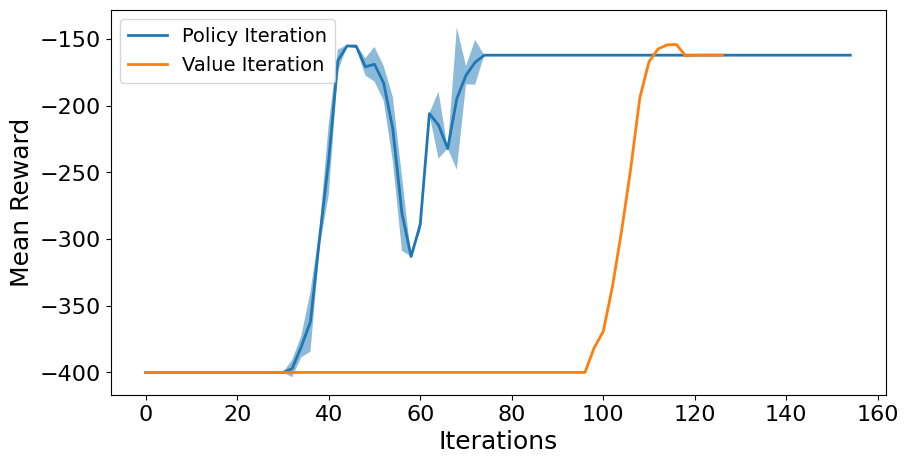

In [77]:
# 2 subplots (one for mean reward and one for mean length)

plt.figure(figsize=(10, 5))
plt.plot(range(0,len(mean_reward_pi)*2, 2),mean_reward_pi, linewidth=2, label="Policy Iteration")
plt.fill_between(range(0,len(mean_reward_pi)*2, 2), mean_reward_pi-std_reward_pi, mean_reward_pi+std_reward_pi, alpha=0.5)
plt.plot(range(0,len(mean_rewards_vi)*2, 2),mean_rewards_vi, linewidth=2, label="Value Iteration")
plt.legend(fontsize=14)
plt.xlabel("Iterations", fontsize=18)
plt.ylabel("Mean Reward", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig("figures/mountain_cart/mean_reward_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()

## 5. State space size study

In [4]:
sizes = [160, 200, 500, 1000]

In [12]:
mc = gym.make('MountainCar-v0', render_mode="rgb_array", max_episode_steps=400)
env = MountainCartWrapper(mc, discrete_step=150)
V, V_track, pi, pi_track, timings  = Planner(env.P).value_iteration(gamma=0.99, theta=1e-8, n_iters=10000)


Total Q updates: 8572500
runtime = 5.41 seconds


In [13]:
# evaluate policy with testenv
episode_rewards, run_length, _ = TestEnv.test_env(env=env, n_iters=100, pi=pi, convert_state_obs=lambda state : env.convert_2d_to_1d(state))
episode_rewards = np.array(episode_rewards)
print(f"Mean reward: {np.mean(episode_rewards)}")

Mean reward: -218.93


In [14]:
len(pi_track)

127

# Q-Learning

## Tests on gamma

In [2]:
size = 25
env = gym.make('MountainCar-v0', render_mode="rgb_array", max_episode_steps=400)
env = MountainCartWrapper(env, discrete_step=size)

In [3]:
from utils import multi_seed_q_learning
q_params = {
    "nS": size*size,
    "convert_state_obs": lambda state : env.convert_2d_to_1d(state),
    "nA": 3,
    "gamma": .9,
    "init_alpha": 0.9,
    "min_alpha": 0.01,
    "alpha_decay_ratio": 0.5,
    "init_epsilon": 1.0,
    "min_epsilon": 0.01,
    "epsilon_decay_ratio": 0.9,
    "n_episodes": 10000
}
results = multi_seed_q_learning(env, n_seeds=5, **q_params)

Running Q-learning for seed 0


  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Running Q-learning for seed 1

/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")



Running Q-learning for seed 2


  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Running Q-learning for seed 3


  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")
/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


Running Q-learning for seed 4

/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
  0%|          | 5/10000 [00:00<03:50, 43.44it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


runtime = 188.38 seconds


runtime = 199.81 seconds


runtime = 274.66 seconds


runtime = 288.17 seconds


runtime = 293.34 seconds


In [7]:
results_gamma_09 = results

runtime = 188.38 seconds
                                                    
runtime = 199.81 seconds
                                                    
runtime = 274.66 seconds
                                                    
runtime = 288.17 seconds
                                                    
runtime = 293.34 seconds

In [11]:
#save results to pickle
with open("checkpoints/mountain_cart_q_learning_gamma_09.pkl", "wb") as f:
    pickle.dump(results, f)

In [ ]:
from utils import multi_seed_q_learning
q_params = {
    "nS": size*size,
    "convert_state_obs": lambda state : env.convert_2d_to_1d(state),
    "nA": 3,
    "gamma": .75,
    "init_alpha": 0.9,
    "min_alpha": 0.01,
    "alpha_decay_ratio": 0.5,
    "init_epsilon": 1.0,
    "min_epsilon": 0.01,
    "epsilon_decay_ratio": 0.9,
    "n_episodes": 10000
}
results_075 = multi_seed_q_learning(env, n_seeds=5, **q_params)

Running Q-learning for seed 0


  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


Running Q-learning for seed 1


  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Running Q-learning for seed 2


  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Running Q-learning for seed 3


/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")
  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


Running Q-learning for seed 4

/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")
  0%|          | 5/10000 [00:00<03:53, 42.87it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


runtime = 238.39 seconds


runtime = 321.77 seconds


runtime = 343.95 seconds

runtime = 343.92 seconds


runtime = 350.52 seconds


In [4]:
# save results to pickle
with open("checkpoints/mountain_cart_q_learning_gamma_075.pkl", "wb") as f:
    pickle.dump(results_075, f)

In [ ]:
from utils import multi_seed_q_learning
q_params = {
    "nS": size*size,
    "convert_state_obs": lambda state : env.convert_2d_to_1d(state),
    "nA": 3,
    "gamma": .99,
    "init_alpha": 0.9,
    "min_alpha": 0.01,
    "alpha_decay_ratio": 0.5,
    "init_epsilon": 1.0,
    "min_epsilon": 0.01,
    "epsilon_decay_ratio": 0.9,
    "n_episodes": 10000
}
results_099 = multi_seed_q_learning(env, n_seeds=5, **q_params)

import pickle
# save results to pickle
with open("checkpoints/mountain_cart_q_learning_gamma_099.pkl", "wb") as f:
    pickle.dump(results_099, f)

Running Q-learning for seed 0


  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Running Q-learning for seed 1


/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")
  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Running Q-learning for seed 2


/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")
  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


Running Q-learning for seed 3

  0%|          | 4/10000 [00:00<04:18, 38.74it/s]

  0%|          | 0/10000 [00:00<?, ?it/s].90it/s]

Running Q-learning for seed 4

/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
  0%|          | 4/10000 [00:00<05:29, 30.32it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")
/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


runtime = 296.21 seconds


runtime = 298.39 seconds


runtime = 299.43 seconds


runtime = 302.44 seconds


runtime = 302.81 seconds


In [3]:
from utils import multi_seed_q_learning
q_params = {
    "nS": size*size,
    "convert_state_obs": lambda state : env.convert_2d_to_1d(state),
    "nA": 3,
    "gamma": .999,
    "init_alpha": 0.9,
    "min_alpha": 0.01,
    "alpha_decay_ratio": 0.5,
    "init_epsilon": 1.0,
    "min_epsilon": 0.01,
    "epsilon_decay_ratio": 0.9,
    "n_episodes": 10000
}
results_0999 = multi_seed_q_learning(env, n_seeds=5, **q_params)

import pickle
# save results to pickle
with open("checkpoints/mountain_cart_q_learning_gamma_0999.pkl", "wb") as f:
    pickle.dump(results_0999, f)

Running Q-learning for seed 0


  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


Running Q-learning for seed 1


  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Running Q-learning for seed 2


  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


Running Q-learning for seed 3


  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
  0%|          | 5/10000 [00:00<04:00, 41.54it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


Running Q-learning for seed 4

/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
  0%|          | 4/10000 [00:00<05:12, 32.00it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


runtime = 294.15 seconds


runtime = 295.14 seconds


runtime = 295.67 seconds


runtime = 296.15 seconds


100%|█████████▉| 9981/10000 [04:57<00:00, 75.67it/s]

runtime = 297.85 seconds

In [18]:
from utils import get_steps_per_episode_from_multi_seed, get_mean_std_steps

import pickle
# load results from pickle
with open("checkpoints/mountain_cart_q_learning_gamma_075.pkl", "rb") as f:
    results_099 = pickle.load(f)

steps_per_episode = get_steps_per_episode_from_multi_seed(results_099)
mean_steps, std_steps = get_mean_std_steps(steps_per_episode)

from utils import eval_multi_seed
mean_rewards, std_reward_pi = eval_multi_seed(env, results_099, convert_state_obs=lambda state : env.convert_2d_to_1d(state))
mean_rewards, std_reward_pi

(387.56, 22.458976824423683)

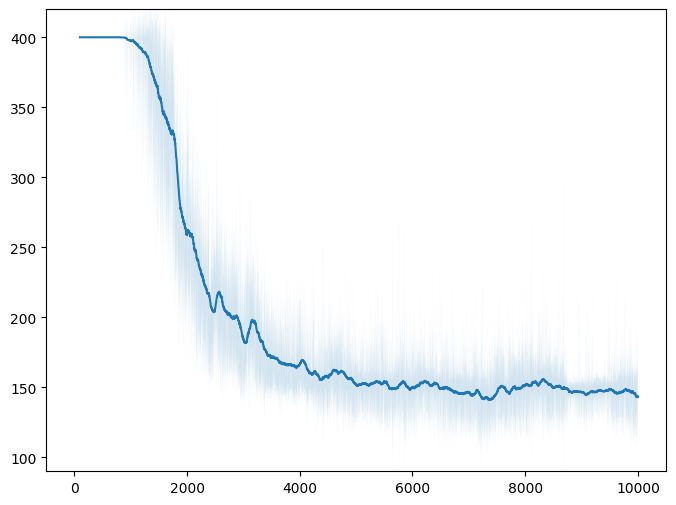

In [8]:
# plot rolling mean of mean_steps_per_episode with window of 100
plt.figure(figsize=(8, 6))
plt.ylim(90, 420)
plt.plot(pd.Series(mean_steps).rolling(window=100).mean(), label="gamma=0.999")
plt.fill_between(range(len(mean_steps)), mean_steps-std_steps, mean_steps+std_steps, alpha=0.2)

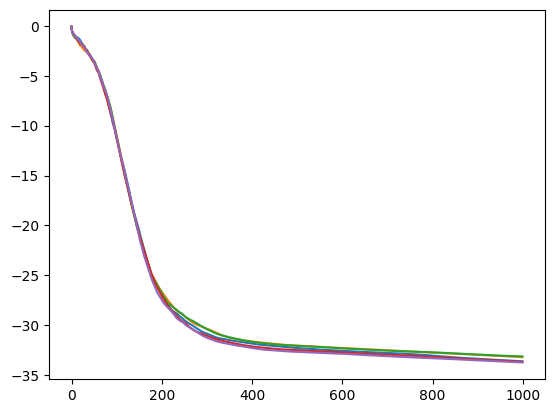

In [7]:
# given Q_track, plot the mean Q value per iteration
for key in results_0999:
    res = results_0999[key]
    q_means = []
    for i in range(0, len(res['Q_track']), 10):
        q_means.append(np.mean(res['Q_track'][i]))

    plt.plot(q_means)

In [55]:
from utils import eval_multi_seed
mean_rewards, std_reward_pi = eval_multi_seed(env, results, convert_state_obs=lambda state : env.convert_2d_to_1d(state))

In [56]:
mean_rewards, std_reward_pi

(154.01, 20.67946034112109)

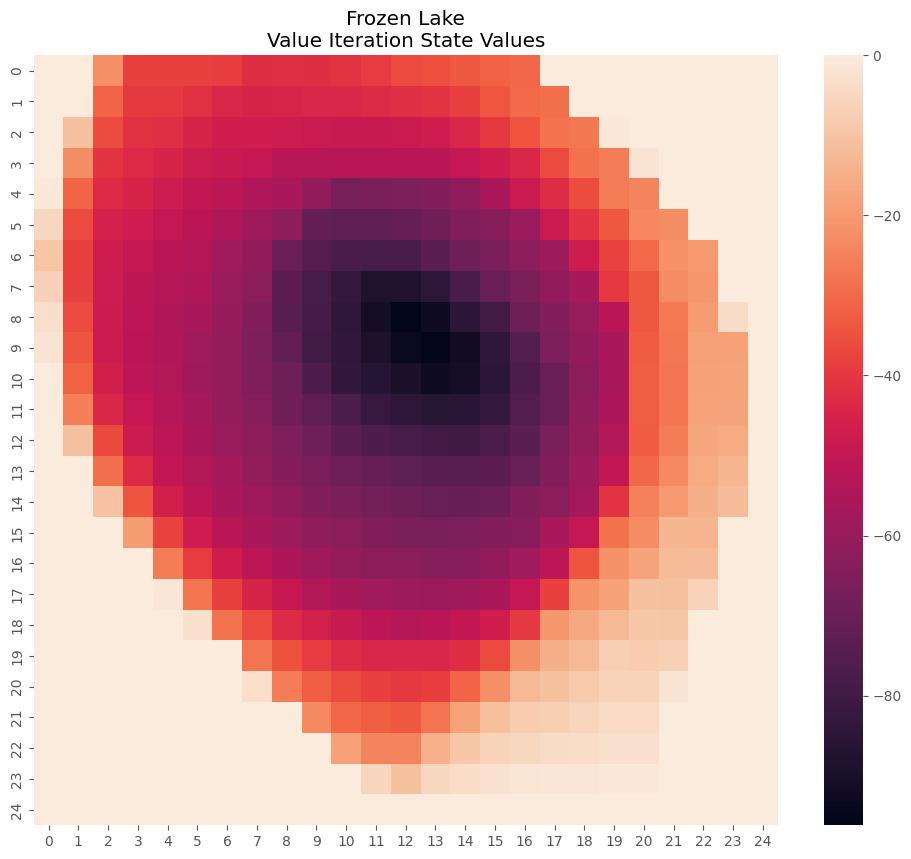

In [19]:
Plots.values_heat_map(V, "Frozen Lake\nValue Iteration State Values", (size,size), annot=False, figsize=(12,10))

In [57]:
def one_shot_eval(env, pi):
    episode_rewards, run_length, _ = TestEnv.test_env(env=env, n_iters=100, pi=pi, convert_state_obs=lambda state : env.convert_2d_to_1d(state))
    episode_rewards = np.array(episode_rewards)
    print(f"Mean reward: {np.mean(episode_rewards)}")

    return episode_rewards
    
ep_rewards= one_shot_eval(env, results[0]['pi'])

Mean reward: -120.88


Score:  116


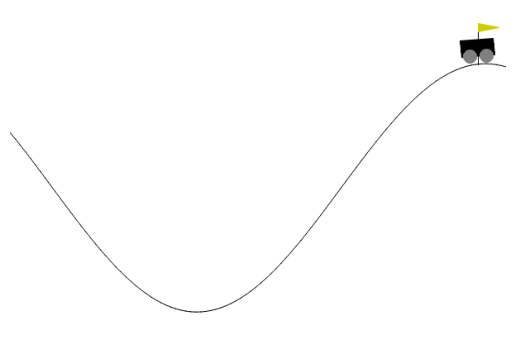

In [66]:
%matplotlib inline
plt.style.use('ggplot')
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

pi = results[0]['pi']


#  Let's see how the agent performs in the environment by running a single iteration of 1000 steps
# and rendering the environment at each step
env.reset()
state = env.state
# print(state)

img = plt.imshow(env.render())
state = env.transform_obs(state)

for t in range(500):
    state = env.convert_2d_to_1d(state)
    action = pi[state]
    img.set_data(env.render())
    # add the action on the image
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, b, c = env.step(action)
    test = env._inverse_transform_obs(state)
    if done:
        print('Score: ', t+1)
        break
        
env.close()

## Exploration vs. Exploitation

In [4]:
size = 25
env = gym.make('MountainCar-v0', render_mode="rgb_array", max_episode_steps=400)
env = MountainCartWrapper(env, discrete_step=size)

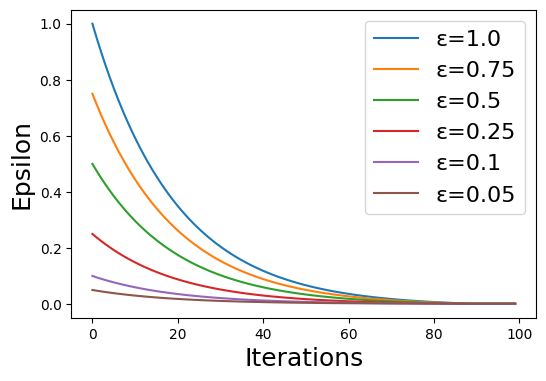

In [5]:
# create a figure with 2 subplots
plt.figure(figsize=(6,4))  


epsilons1 = RL(env).decay_schedule(1.0, 0.001, 0.9, 100)
epsilons075 = RL(env).decay_schedule(0.75, 0.001, 0.9, 100)
epsilons050 = RL(env).decay_schedule(0.5, 0.001, 0.9, 100)
epsilons025 = RL(env).decay_schedule(0.25, 0.001, 0.9, 100)
epsilons010 = RL(env).decay_schedule(0.1, 0.001, 0.9, 100)
epsilons005 = RL(env).decay_schedule(0.05, 0.001, 0.9, 100)
epsilons5 = RL(env).decay_schedule(1.0, 1.0, 1, 100)
plt.plot(epsilons1, label="ε=1.0")
plt.plot(epsilons075, label="ε=0.75")
plt.plot(epsilons050, label="ε=0.5")
plt.plot(epsilons025, label="ε=0.25")
plt.plot(epsilons010, label="ε=0.1")
plt.plot(epsilons005, label="ε=0.05")
plt.xlabel("Iterations", fontsize=18)
plt.ylabel("Epsilon", fontsize=18)
plt.legend(fontsize=16)
plt.savefig("figures/mountain_cart/epsilon_decay.pdf", format="pdf", bbox_inches="tight")



In [12]:
gs = {}

In [5]:
from utils import multi_seed_q_learning
q_params = {
    "nS": size*size,
    "convert_state_obs": lambda state : env.convert_2d_to_1d(state),
    "nA": 3,
    "gamma": .99,
    "init_alpha": 0.5,
    "min_alpha": 0.01,
    "alpha_decay_ratio": 0.5,
    "init_epsilon": 1.0,
    "min_epsilon": 0.01,
    "epsilon_decay_ratio": 0.9,
    "n_episodes": 10000
}
results = multi_seed_q_learning(env, n_seeds=3, **q_params)

Running Q-learning for seed 0


  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Running Q-learning for seed 1


/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")
  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Running Q-learning for seed 2

/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


runtime = 142.62 seconds


runtime = 145.72 seconds


runtime = 145.78 seconds


In [18]:
gs['1'] = results

In [19]:
# change the '1' key to 1
gs[1] = gs.pop('1')

In [15]:
from utils import multi_seed_q_learning
q_params = {
    "nS": size*size,
    "convert_state_obs": lambda state : env.convert_2d_to_1d(state),
    "nA": 3,
    "gamma": .99,
    "init_alpha": 0.5,
    "min_alpha": 0.01,
    "alpha_decay_ratio": 0.5,
    "init_epsilon": 0.75,
    "min_epsilon": 0.01,
    "epsilon_decay_ratio": 0.9,
    "n_episodes": 10000
}
results = multi_seed_q_learning(env, n_seeds=3, **q_params)

Running Q-learning for seed 0


  0%|          | 0/10000 [00:00<?, ?it/s]

Running Q-learning for seed 1


  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


Running Q-learning for seed 2


/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")
  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


runtime = 124.83 seconds


runtime = 126.05 seconds


runtime = 127.06 seconds
Running Q-learning for seed 0


In [16]:
gs[0.75] = results

In [21]:
from utils import multi_seed_q_learning
q_params = {
    "nS": size*size,
    "convert_state_obs": lambda state : env.convert_2d_to_1d(state),
    "nA": 3,
    "gamma": .99,
    "init_alpha": 0.5,
    "min_alpha": 0.01,
    "alpha_decay_ratio": 0.5,
    "init_epsilon": 0.5,
    "min_epsilon": 0.01,
    "epsilon_decay_ratio": 0.9,
    "n_episodes": 10000
}
results = multi_seed_q_learning(env, n_seeds=3, **q_params)
gs[0.5] =  results

  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


Running Q-learning for seed 1


  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")
  0%|          | 7/10000 [00:00<02:32, 65.34it/s]

Running Q-learning for seed 2


runtime = 120.84 seconds


runtime = 121.45 seconds


runtime = 121.95 seconds
Running Q-learning for seed 0


In [22]:
from utils import multi_seed_q_learning
q_params = {
    "nS": size*size,
    "convert_state_obs": lambda state : env.convert_2d_to_1d(state),
    "nA": 3,
    "gamma": .99,
    "init_alpha": 0.5,
    "min_alpha": 0.01,
    "alpha_decay_ratio": 0.5,
    "init_epsilon": 0.25,
    "min_epsilon": 0.01,
    "epsilon_decay_ratio": 0.9,
    "n_episodes": 10000
}
results = multi_seed_q_learning(env, n_seeds=3, **q_params)
gs[0.25] =  results

  0%|          | 0/10000 [00:00<?, ?it/s]

Running Q-learning for seed 1


  0%|          | 6/10000 [00:00<02:56, 56.67it/s]

Running Q-learning for seed 2


runtime = 128.49 seconds


runtime = 128.85 seconds


100%|██████████| 10000/10000 [02:12<00:00, 142.25it/s]

runtime = 132.95 secondsRunning Q-learning for seed 0


In [26]:
from utils import multi_seed_q_learning
q_params = {
    "nS": size*size,
    "convert_state_obs": lambda state : env.convert_2d_to_1d(state),
    "nA": 3,
    "gamma": .99,
    "init_alpha": 0.5,
    "min_alpha": 0.01,
    "alpha_decay_ratio": 0.5,
    "init_epsilon": 0.1,
    "min_epsilon": 0.01,
    "epsilon_decay_ratio": 0.9,
    "n_episodes": 10000
}
results = multi_seed_q_learning(env, n_seeds=3, **q_params)
gs[0.1] =  results

  0%|          | 0/10000 [00:00<?, ?it/s]

Running Q-learning for seed 1


  0%|          | 6/10000 [00:00<02:49, 58.98it/s]

Running Q-learning for seed 2


runtime = 151.27 seconds


runtime = 157.21 seconds


runtime = 160.92 seconds
Running Q-learning for seed 0


In [78]:
from utils import multi_seed_q_learning
q_params = {
    "nS": size*size,
    "convert_state_obs": lambda state : env.convert_2d_to_1d(state),
    "nA": 3,
    "gamma": .99,
    "init_alpha": 0.5,
    "min_alpha": 0.01,
    "alpha_decay_ratio": 0.5,
    "init_epsilon": 0.05,
    "min_epsilon": 0.01,
    "epsilon_decay_ratio": 0.9,
    "n_episodes": 10000
}
results = multi_seed_q_learning(env, n_seeds=3, **q_params)
gs[0.05] =  results

  0%|          | 0/10000 [00:00<?, ?it/s]

Running Q-learning for seed 1


  0%|          | 5/10000 [00:00<03:42, 44.99it/s]

Running Q-learning for seed 2


runtime = 150.48 seconds


runtime = 152.41 seconds


runtime = 154.23 seconds


In [80]:
del results

In [79]:
import pickle
# save gs
with open("checkpoints/mountain_cart_q_learning_epsilon_decay.pkl", "wb") as f:
    pickle.dump(gs, f)

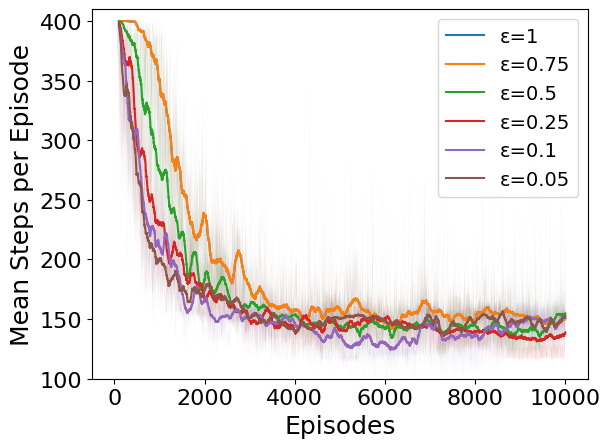

In [89]:
from utils import eval_multi_seed

for key in [1, 0.75, 0.5, 0.25, 0.1, 0.05]:
    steps_per_episode = get_steps_per_episode_from_multi_seed(gs[key])
    mean_steps, std_steps = get_mean_std_steps(steps_per_episode)
    std_steps = std_steps / 3
    plt.plot(pd.Series(mean_steps).rolling(window=100).mean(), label=f"ε={key}")
    plt.fill_between(range(len(mean_steps)), mean_steps-std_steps, mean_steps+std_steps, alpha=0.3)
    plt.legend(fontsize=14)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(100, 410)
plt.xlabel("Episodes", fontsize=18)
plt.ylabel("Mean Steps per Episode", fontsize=18)
plt.savefig("figures/mountain_cart/epsilon_decay_steps.pdf", format="pdf", bbox_inches="tight")

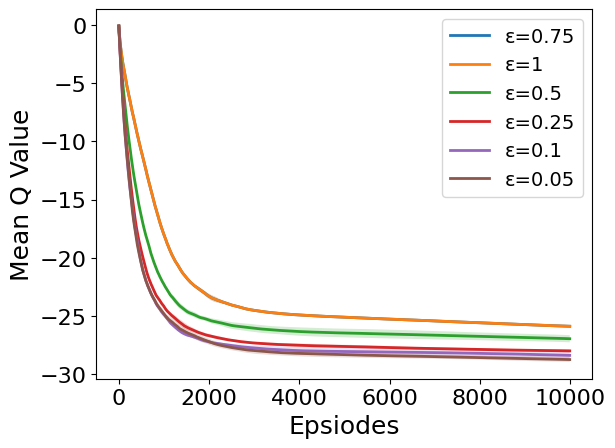

In [83]:
for key in gs:
    q_means = []
    for seed in gs[key]:
        res = gs[key][seed]
        q_mean = []
        for i in range(0, len(res['Q_track']), 10):
            q_mean.append([np.mean(res['Q_track'][i])])
        q_means.append(q_mean)

    q_std = np.std(q_means, axis=0).squeeze()
    q_mean = np.mean(q_means, axis=0).squeeze()
    plt.plot(range(0,len(q_mean)*10,10), q_mean, label=f"ε={key}", linewidth=2)
    plt.fill_between(range(0,len(q_mean)*10,10), q_mean-q_std, q_mean+q_std, alpha=0.2)
    plt.legend(fontsize=14)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Epsiodes", fontsize=18)
plt.ylabel("Mean Q Value", fontsize=18)
plt.savefig("figures/mountain_cart/epsilon_decay_q_values.pdf", format="pdf", bbox_inches="tight")

In [87]:
for key in gs:
    mean_rewards, std_rewards = eval_multi_seed(env, gs[key], convert_state_obs=lambda state : env.convert_2d_to_1d(state))
    print(f"Mean reward for epsilon={key}: {np.mean(mean_rewards)} (+/-) {std_rewards}")

Mean reward for epsilon=0.75: 153.72666666666666 (+/-) 5.106050876710451
Mean reward for epsilon=1: 153.72666666666666 (+/-) 5.106050876710451
Mean reward for epsilon=0.5: 162.4933333333333 (+/-) 11.101994815747702
Mean reward for epsilon=0.25: 139.07666666666668 (+/-) 10.227982314328779
Mean reward for epsilon=0.1: 151.00333333333333 (+/-) 20.182742353032427
Mean reward for epsilon=0.05: 153.45 (+/-) 10.71477484597786


In [90]:
# create a dict gs_stats that will contain the mean rewards and std for each epsilon over iterations as well as the mean q value over iteration
gs_stats = {}
for key in gs:
    mean_rewards, std_rewards = eval_multi_seed(env, gs[key], convert_state_obs=lambda state : env.convert_2d_to_1d(state))
    steps_per_episode = get_steps_per_episode_from_multi_seed(gs[key])
    mean_steps, std_steps = get_mean_std_steps(steps_per_episode)
    q_means = []
    for seed in gs[key]:
        res = gs[key][seed]
        q_mean = []
        for i in range(0, len(res['Q_track']), 10):
            q_mean.append([np.mean(res['Q_track'][i])])
        q_means.append(q_mean)

    q_std = np.std(q_means, axis=0).squeeze()
    q_mean = np.mean(q_means, axis=0).squeeze()
    gs_stats[key] = {
        "mean_steps": mean_steps,
        "std_steps": std_steps,
        "q_mean": q_mean,
        "q_std": q_std
    }

In [93]:
# save gs_stats
with open("checkpoints/mountain_cart_q_learning_epsilon_decay_stats.pkl", "wb") as f:
    pickle.dump(gs_stats, f)

### Now test with no epsilon decay

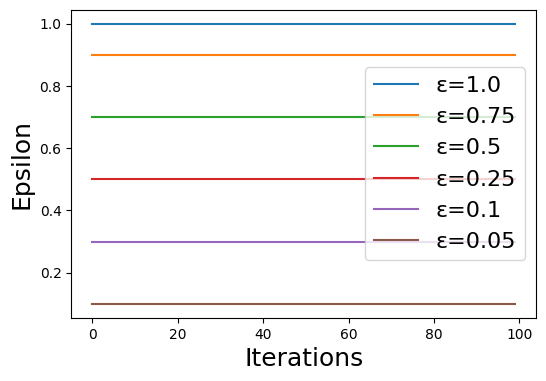

In [6]:
# create a figure with 2 subplots
plt.figure(figsize=(6,4))  


epsilons1 = RL(env).decay_schedule(1.0, 1, 0.9, 100)
epsilons075 = RL(env).decay_schedule(0.9, 0.9, 0.9, 100)
epsilons050 = RL(env).decay_schedule(0.7, 0.7, 0.9, 100)
epsilons025 = RL(env).decay_schedule(0.5, 0.5, 0.9, 100)
epsilons010 = RL(env).decay_schedule(0.3, 0.3, 0.9, 100)
epsilons005 = RL(env).decay_schedule(0.1, 0.1, 0.9, 100)
epsilons5 = RL(env).decay_schedule(0.05, 0.05, 1, 100)
plt.plot(epsilons1, label="ε=1.0")
plt.plot(epsilons075, label="ε=0.75")
plt.plot(epsilons050, label="ε=0.5")
plt.plot(epsilons025, label="ε=0.25")
plt.plot(epsilons010, label="ε=0.1")
plt.plot(epsilons005, label="ε=0.05")
plt.xlabel("Iterations", fontsize=18)
plt.ylabel("Epsilon", fontsize=18)
plt.legend(fontsize=16)



In [7]:
gsn={}

In [8]:
from utils import multi_seed_q_learning
q_params = {
    "nS": size*size,
    "convert_state_obs": lambda state : env.convert_2d_to_1d(state),
    "nA": 3,
    "gamma": .99,
    "init_alpha": 0.5,
    "min_alpha": 0.01,
    "alpha_decay_ratio": 0.5,
    "init_epsilon": 0.9,
    "min_epsilon": 0.9,
    "epsilon_decay_ratio": 0.9,
    "n_episodes": 10000
}
results = multi_seed_q_learning(env, n_seeds=3, **q_params)
gsn[0.9] =  results

Running Q-learning for seed 0


  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Running Q-learning for seed 1


/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")
  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Running Q-learning for seed 2


/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")
  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


runtime = 303.09 seconds


runtime = 304.11 seconds


runtime = 304.70 seconds


In [9]:
from utils import multi_seed_q_learning
q_params = {
    "nS": size*size,
    "convert_state_obs": lambda state : env.convert_2d_to_1d(state),
    "nA": 3,
    "gamma": .99,
    "init_alpha": 0.5,
    "min_alpha": 0.01,
    "alpha_decay_ratio": 0.5,
    "init_epsilon": 0.75,
    "min_epsilon": 0.75,
    "epsilon_decay_ratio": 0.9,
    "n_episodes": 10000
}
results = multi_seed_q_learning(env, n_seeds=3, **q_params)
gsn[0.75] =  results

Running Q-learning for seed 0


  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


Running Q-learning for seed 1


  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


Running Q-learning for seed 2


  0%|          | 0/10000 [00:00<?, ?it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
  0%|          | 4/10000 [00:00<04:54, 33.93it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


runtime = 299.85 seconds


runtime = 301.64 seconds


runtime = 302.47 seconds
Running Q-learning for seed 0


In [19]:
from utils import multi_seed_q_learning
q_params = {
    "nS": size*size,
    "convert_state_obs": lambda state : env.convert_2d_to_1d(state),
    "nA": 3,
    "gamma": .99,
    "init_alpha": 0.5,
    "min_alpha": 0.01,
    "alpha_decay_ratio": 0.5,
    "init_epsilon": 0.5,
    "min_epsilon": 0.5,
    "epsilon_decay_ratio": 0.9,
    "n_episodes": 10000
}
results = multi_seed_q_learning(env, n_seeds=3, **q_params)
gsn[0.5] =  results

  0%|          | 0/10000 [00:00<?, ?it/s]

Running Q-learning for seed 1


  0%|          | 0/10000 [00:00<?, ?it/s].24it/s]

Running Q-learning for seed 2


runtime = 199.37 seconds


runtime = 200.16 seconds


runtime = 201.61 seconds
Running Q-learning for seed 0


In [20]:
from utils import multi_seed_q_learning
q_params = {
    "nS": size*size,
    "convert_state_obs": lambda state : env.convert_2d_to_1d(state),
    "nA": 3,
    "gamma": .99,
    "init_alpha": 0.3,
    "min_alpha": 0.01,
    "alpha_decay_ratio": 0.5,
    "init_epsilon": 0.3,
    "min_epsilon": 0.3,
    "epsilon_decay_ratio": 0.9,
    "n_episodes": 10000
}
results = multi_seed_q_learning(env, n_seeds=3, **q_params)
gsn[0.3] =  results

  0%|          | 0/10000 [00:00<?, ?it/s]

Running Q-learning for seed 1


  0%|          | 6/10000 [00:00<02:51, 58.17it/s]

Running Q-learning for seed 2


runtime = 165.02 seconds


runtime = 165.79 seconds


runtime = 169.26 seconds
Running Q-learning for seed 0
Running Q-learning for seed 2

In [12]:
from utils import multi_seed_q_learning
q_params = {
    "nS": size*size,
    "convert_state_obs": lambda state : env.convert_2d_to_1d(state),
    "nA": 3,
    "gamma": .99,
    "init_alpha": 0.3,
    "min_alpha": 0.01,
    "alpha_decay_ratio": 0.5,
    "init_epsilon": 0.1,
    "min_epsilon": 0.1,
    "epsilon_decay_ratio": 0.9,
    "n_episodes": 10000
}
results = multi_seed_q_learning(env, n_seeds=3, **q_params)
gsn[0.1] =  results

  0%|          | 0/10000 [00:00<?, ?it/s]

Running Q-learning for seed 1


  0%|          | 0/10000 [00:00<?, ?it/s]

Running Q-learning for seed 2


runtime = 357.15 seconds


runtime = 357.45 seconds


runtime = 359.13 seconds
Running Q-learning for seed 0


In [23]:
from utils import multi_seed_q_learning
q_params = {
    "nS": size*size,
    "convert_state_obs": lambda state : env.convert_2d_to_1d(state),
    "nA": 3,
    "gamma": .99,
    "init_alpha": 0.3,
    "min_alpha": 0.01,
    "alpha_decay_ratio": 0.5,
    "init_epsilon": 0.05,
    "min_epsilon": 0.05,
    "epsilon_decay_ratio": 0.9,
    "n_episodes": 10000
}
results = multi_seed_q_learning(env, n_seeds=3, **q_params)
gsn[0.05] =  results

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Running Q-learning for seed 1

  0%|          | 6/10000 [00:00<02:53, 57.73it/s]

runtime = 163.49 seconds


runtime = 165.69 seconds


runtime = 166.16 seconds


In [14]:
# save gsn
with open("checkpoints/mountain_cart_q_learning_epsilon_decay_no_decay.pkl", "wb") as f:
    pickle.dump(gsn, f)

In [25]:
gsn_stats = {}
for key in gsn:
    mean_rewards, std_rewards = eval_multi_seed(env, gsn[key], convert_state_obs=lambda state : env.convert_2d_to_1d(state))
    steps_per_episode = get_steps_per_episode_from_multi_seed(gsn[key])
    mean_steps, std_steps = get_mean_std_steps(steps_per_episode)
    q_means = []
    for seed in gsn[key]:
        res = gsn[key][seed]
        q_mean = []
        for i in range(0, len(res['Q_track']), 10):
            q_mean.append([np.mean(res['Q_track'][i])])
        q_means.append(q_mean)

    q_std = np.std(q_means, axis=0).squeeze()
    q_mean = np.mean(q_means, axis=0).squeeze()
    gsn_stats[key] = {
        "mean_steps": mean_steps,
        "std_steps": std_steps,
        "q_mean": q_mean,
        "q_std": q_std
    }

In [26]:
# save gsn_stats
with open("checkpoints/mountain_cart_q_learning_epsilon_decay_no_decay_stats.pkl", "wb") as f:
    pickle.dump(gsn_stats, f)

In [27]:
gsn.keys()

dict_keys([0.9, 0.75, 0.5, 0.1, 0.3, 0.05])

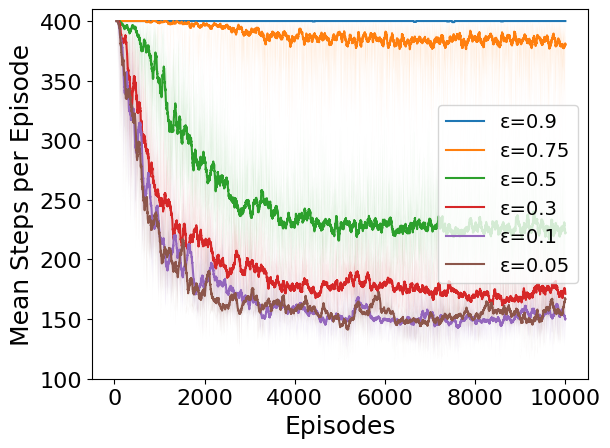

In [33]:
from utils import eval_multi_seed

for key in [0.9, 0.75, 0.5, 0.3, 0.1, 0.05]:
    steps_per_episode = get_steps_per_episode_from_multi_seed(gsn[key])
    mean_steps, std_steps = get_mean_std_steps(steps_per_episode)
    std_steps = std_steps / 3
    plt.plot(pd.Series(mean_steps).rolling(window=50).mean(), label=f"ε={key}")
    plt.fill_between(range(len(mean_steps)), mean_steps-std_steps, mean_steps+std_steps, alpha=0.3)
    plt.legend(fontsize=14)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(100, 410)
plt.xlabel("Episodes", fontsize=18)
plt.ylabel("Mean Steps per Episode", fontsize=18)
plt.savefig("figures/mountain_cart/epsilon_no_decay_steps.pdf", format="pdf", bbox_inches="tight")

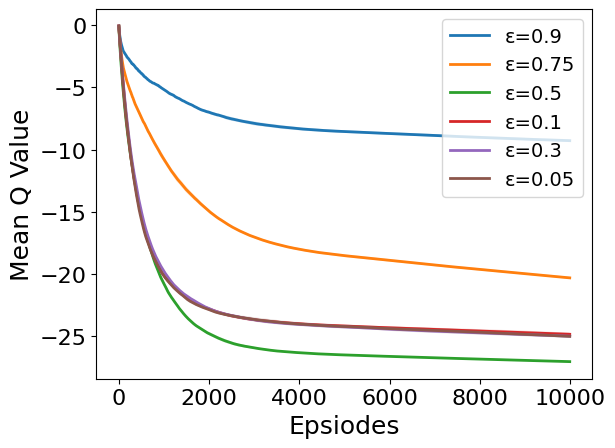

In [32]:
for key in gsn:
    q_means = []
    for seed in gsn[key]:
        res = gsn[key][seed]
        q_mean = []
        for i in range(0, len(res['Q_track']), 10):
            q_mean.append([np.mean(res['Q_track'][i])])
        q_means.append(q_mean)

    q_std = np.std(q_means, axis=0).squeeze()
    q_mean = np.mean(q_means, axis=0).squeeze()
    plt.plot(range(0,len(q_mean)*10,10), q_mean, label=f"ε={key}", linewidth=2)
    plt.fill_between(range(0,len(q_mean)*10,10), q_mean-q_std, q_mean+q_std, alpha=0.2)
    plt.legend(fontsize=14)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Epsiodes", fontsize=18)
plt.ylabel("Mean Q Value", fontsize=18)
plt.savefig("figures/mountain_cart/epsilon_no_decay_q_values.pdf", format="pdf", bbox_inches="tight")

In [29]:
for key in gsn:
    mean_rewards, std_rewards = eval_multi_seed(env, gsn[key], convert_state_obs=lambda state : env.convert_2d_to_1d(state))
    print(f"Mean reward for epsilon={key}: {np.mean(mean_rewards)} (+/-) {std_rewards}")

Mean reward for epsilon=0.9: 237.51 (+/-) 115.04045752111153
Mean reward for epsilon=0.75: 133.57000000000002 (+/-) 2.3975125998973743
Mean reward for epsilon=0.5: 129.77333333333334 (+/-) 2.5447243902281826
Mean reward for epsilon=0.1: 148.14333333333335 (+/-) 12.98279973229537
Mean reward for epsilon=0.3: 137.78333333333333 (+/-) 9.248438907308751
Mean reward for epsilon=0.05: 163.39333333333332 (+/-) 5.2281885539406066


In [40]:
gsn[0.5][0].keys()

dict_keys(['Q', 'V', 'pi', 'Q_track', 'pi_track', 'steps_per_episode'])

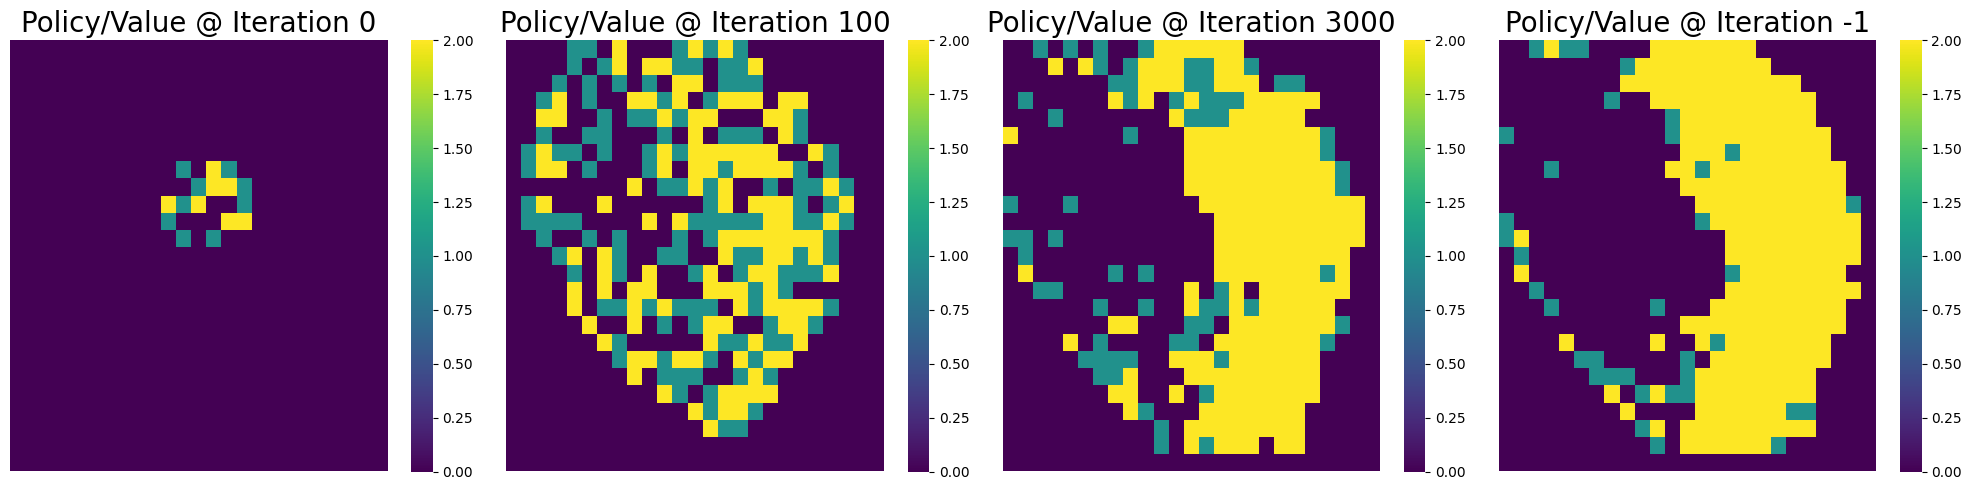

In [62]:
plot_multiple_policies(gsn[0.5][0]['Q_track'], gsn[0.5][0]['pi_track'], [0,100,3000,-1], map_size=(25,25), filename="25x25")

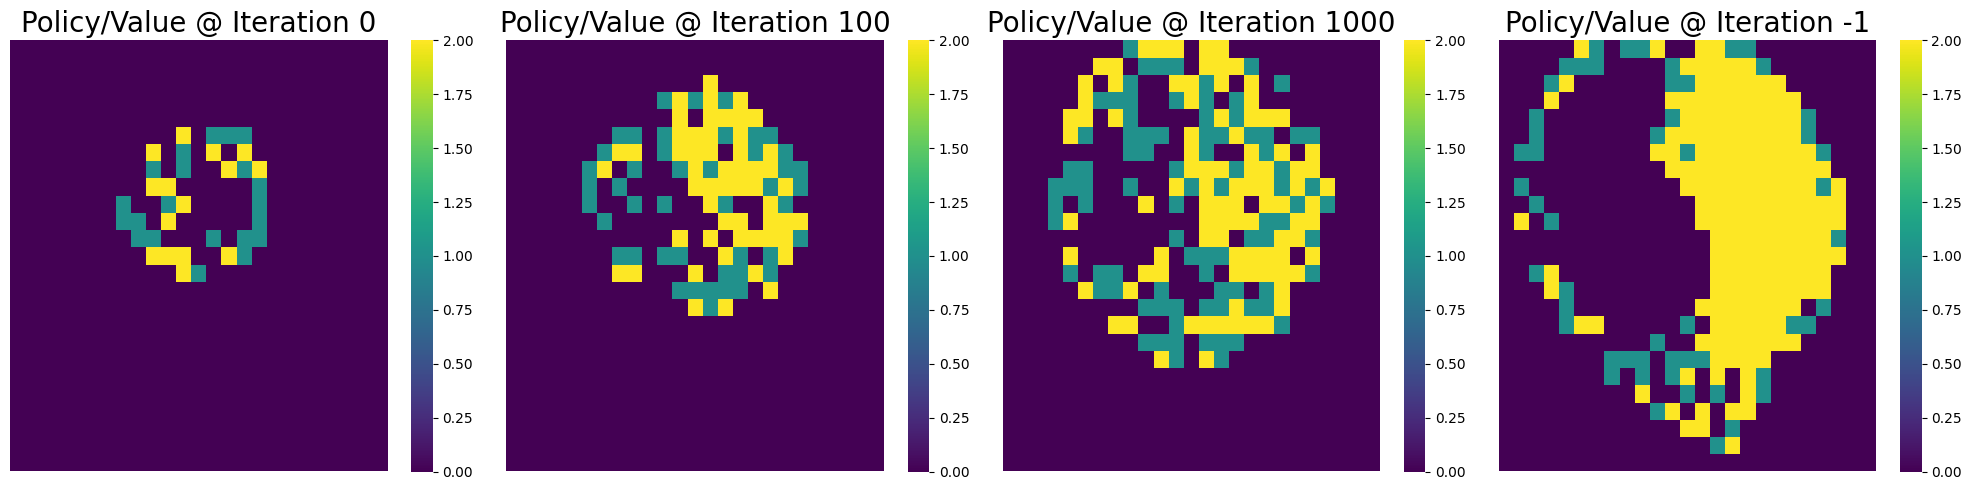

In [46]:
plot_multiple_policies(gsn[0.9][0]['Q_track'], gsn[0.9][0]['pi_track'], [0,100,1000,-1], map_size=(25,25), filename="160x160")

In [2]:
import pickle
# load gsn
with open("checkpoints/mountain_cart_q_learning_epsilon_decay_no_decay.pkl", "rb") as f:
    gsn = pickle.load(f)

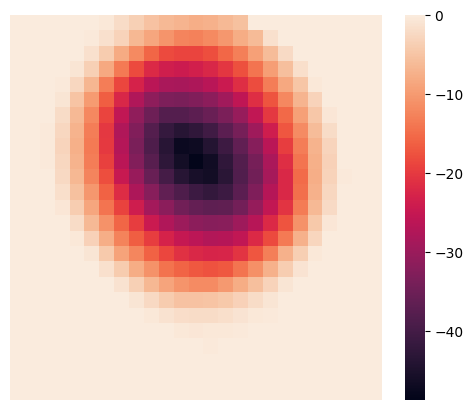

In [13]:
Plots.values_heat_map(gsn[0.9][0]['V'], "09", (25,25), annot=False, figsize=(6,5))

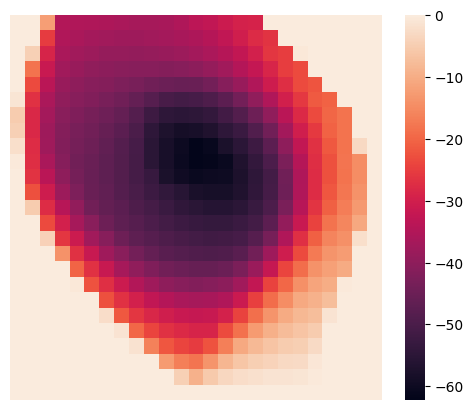

In [14]:
Plots.values_heat_map(gsn[0.5][0]['V'], "05", (25,25), annot=False, figsize=(6,5))

In [11]:
# import gs
with open("checkpoints/mountain_cart_q_learning_epsilon_decay.pkl", "rb") as f:
    gs = pickle.load(f)

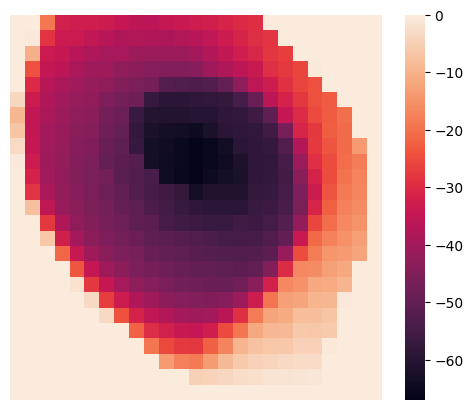

In [15]:
Plots.values_heat_map(gs[0.25][0]['V'], "025decay", (25,25), annot=False, figsize=(6,5))

In [63]:
del results

In [65]:
del gs

In [66]:
del gsn

In [67]:
del gsn_stats

## Tests on DSS size

In [2]:
gss = {}

In [23]:
size = 25
mc = gym.make('MountainCar-v0', render_mode="rgb_array", max_episode_steps=400)
env25 = MountainCartWrapper(mc, discrete_step=size)

In [30]:
Q_25, V_25, pi_25, _, _, steps_per_episode_25 = RL(env25).q_learning(
    nS=25*25,
    convert_state_obs= lambda state : env.convert_2d_to_1d(state),
    nA=3,
    gamma=.99,
    init_epsilon=0.5,
    min_epsilon=0.5,
    epsilon_decay_ratio=0.9995,
    n_episodes=10000
)

  0%|          | 0/10000 [00:00<?, ?it/s]

/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:192: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")
                                                     

runtime = 109.77 seconds


In [31]:
# TEst env
def one_shot_eval(env, pi):
    episode_rewards, run_length, _ = TestEnv.test_env(env=env, n_iters=100, pi=pi, convert_state_obs=lambda state : env.convert_2d_to_1d(state))
    episode_rewards = np.array(episode_rewards)
    print(f"Mean reward: {np.mean(episode_rewards)}")
    
one_shot_eval(env25, pi_25)

Mean reward: -127.64


In [32]:
np.mean(Q_25)

-27.02096274655225

In [26]:
size = 100
mc = gym.make('MountainCar-v0', render_mode="rgb_array", max_episode_steps=400)
env20 = MountainCartWrapper(mc, discrete_step=size)

In [31]:
Q, V, pi, _, _, steps_per_episode = RL(env20).q_learning(
    nS=size*size,
    convert_state_obs= lambda state : env20.convert_2d_to_1d(state),
    nA=3,
    gamma=.99,
    init_epsilon=0.5,
    min_epsilon=0.01,
    epsilon_decay_ratio=0.9995,
    n_episodes=10000
)

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [29]:
# TEst env
def one_shot_eval(env, pi):
    episode_rewards, run_length, _ = TestEnv.test_env(env=env, n_iters=100, pi=pi, convert_state_obs=lambda state : env.convert_2d_to_1d(state))
    episode_rewards = np.array(episode_rewards)
    print(f"Mean reward: {np.mean(episode_rewards)}")
    
one_shot_eval(env20, pi)

Mean reward: -217.57


In [30]:
np.mean(Q)

-6.26013442102528